<a href="https://colab.research.google.com/github/myconcordia/INSE6220/blob/main/Sample_Project_Classification_with_PyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Exploring the Power of PCA and Machine Learning for Speech Emotion Recognition with a Focus on Explainable AI </center>
### <center> Alaa Nfissi: 40215993</center>

In [1]:
# install slim version (default): if you get an error message, run it again
!pip install pycaret==2.3.6
!pip install praat-parselmouth
!pip install librosa

In [2]:
#Run the below code in your notebook to check the installed version
from pycaret.utils import version
version()

'2.3.6'

**Import Libraries**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import pandas as pd
plt.rcParams['figure.figsize'] = (21,15)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
import os
from tqdm.notebook import tqdm
import parselmouth
from feature_extraction_utils import *
import librosa
import librosa.display
import scipy
import random
random.seed(123)

In [5]:
print("Pandas version: ", pd.__version__)
print("Seaborn version: ", sns.__version__)

Pandas version:  1.3.4
Seaborn version:  0.11.2


In [6]:
dataset_name = 'tess'

**Dataset**

The TESS (Toronto emotional speech set) dataset was created by the University of Toronto in 2014. It consists of audio recordings of actors reading two different scripts in different emotions: one with positive emotions and one with negative emotions.

The positive script includes sentences that describe situations or events that typically elicit positive emotions, such as happiness, excitement, and surprise. The negative script includes sentences that describe situations or events that typically elicit negative emotions, such as sadness, anger, and fear.

Each script was read by eight actors of different genders, ages, and ethnicities, resulting in a total of 16 actors. The actors were asked to read the scripts in four different emotions: neutral, happy, sad, and angry. This resulted in a total of 64 recordings per script, for a total of 128 recordings in the dataset.

The recordings were made in a controlled environment using high-quality microphones. The audio was digitally sampled at 16 kHz and the recordings were manually segmented and labeled according to the emotion expressed by the actor.

The TESS dataset is widely used in the development and evaluation of speech emotion recognition (SER) systems. It is well-annotated and provides a balanced representation of different emotions, which makes it a valuable resource for researchers working on SER systems.
https://tspace.library.utoronto.ca/handle/1807/24487

# Load Data

<div class="alert alert-block alert-danger"> This section is about creating our the dataset used in this project, it may be time consuming to run. You can start from the section <a id='Speech-emotion-recognition'>(Speech emotion recognition)</a> where we just read the CSV file obtained from this section.</div>

In [8]:
TESS = os.path.abspath("TESS Toronto emotional speech set data/")
dir_list_TESS = os.listdir(TESS)
print(f'TESS : {dir_list_TESS[0:5]}')

TESS : ['YAF_happy', 'YAF_fear', 'OAF_neutral', 'YAF_neutral', 'OAF_Sad']


In [9]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [10]:
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + "/" + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + "/" + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['label'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.to_csv('tess_dataset.csv', index=False)
TESS_df.label.value_counts()

fear        400
surprise    400
sad         400
angry       400
disgust     400
happy       400
neutral     400
Name: label, dtype: int64

In [11]:
TESS_df.head()

label source                                               path
0  fear   TESS  /home/alaa/Downloads/Concordia/Semesters/Fall ...
1  fear   TESS  /home/alaa/Downloads/Concordia/Semesters/Fall ...
2  fear   TESS  /home/alaa/Downloads/Concordia/Semesters/Fall ...
3  fear   TESS  /home/alaa/Downloads/Concordia/Semesters/Fall ...
4  fear   TESS  /home/alaa/Downloads/Concordia/Semesters/Fall ...

In [14]:
sound_filepaths = TESS_df['path']

# Feature Extraction

### Extract feature set 1

In [15]:
def extract_feature_set_1(sound_filepath):
    sound = parselmouth.Sound(sound_filepath)
    df = pd.DataFrame()
    attributes = {}

    intensity_attributes = get_intensity_attributes(sound)[0]
    pitch_attributes = get_pitch_attributes(sound)[0]
    attributes.update(intensity_attributes)
    attributes.update(pitch_attributes)

    hnr_attributes = get_harmonics_to_noise_ratio_attributes(sound)[0]
    gne_attributes = get_glottal_to_noise_ratio_attributes(sound)[0]
    attributes.update(hnr_attributes)
    attributes.update(gne_attributes)

    df['local_jitter'] = None
    df['local_shimmer'] = None
    df.at[0, 'local_jitter'] = get_local_jitter(sound)
    df.at[0, 'local_shimmer'] = get_local_shimmer(sound)

    spectrum_attributes = get_spectrum_attributes(sound)[0]
    attributes.update(spectrum_attributes)

    formant_attributes = get_formant_attributes(sound)[0]
    attributes.update(formant_attributes)

    for attribute in attributes:
        df.at[0, attribute] = attributes[attribute]
    
    df.at[0, 'sound_filepath'] = sound_filepath
    rearranged_columns = df.columns.tolist()[-1:] + df.columns.tolist()[:-1]
    df = df[rearranged_columns]
    return df

In [16]:
all_df_list = []
source = []
label = []
for i in tqdm(range(len(sound_filepaths))):
    source.append(TESS_df['source'][i])
    label.append(TESS_df['label'][i])
    all_df_list.append(extract_feature_set_1(sound_filepaths[i]))
all_df = pd.concat(all_df_list)
all_df['source'] = source
all_df['class'] = label
all_df.rename(columns={'sound_filepath':'path'}, inplace=True)
all_df.to_csv(dataset_name+'_feature_set_1.csv', index=False)

  0%|          | 0/2800 [00:00<?, ?it/s]

### Extract feature set 2

In [17]:
import math
rms = []
zcr = []
spectral_centroid = []
spectral_bandwidth = []
spectral_contrast = []
spectral_rolloff = []
ptch = []
path = []
source = []
label = []

minF0_list = []
maxF0_list = []
avgF0_list = []
min_intensity_list = []
max_intensity_list = []
avg_intensity_list = []
jitter_list = []
shimmer_list = []
hnr_list = []

for i in tqdm(range(len(TESS_df))):
    y, sr = librosa.load(TESS_df['path'][i])
    S, phase = librosa.magphase(librosa.stft(y))
    rms.append(librosa.feature.rms(S=S).mean())
    zcr.append(librosa.feature.zero_crossing_rate(y).mean())
    spectral_centroid.append(librosa.feature.spectral_centroid(y, sr=sr)[0].mean())
    spectral_bandwidth.append(librosa.feature.spectral_bandwidth(y, sr=sr)[0].mean())
    spectral_contrast.append(librosa.feature.spectral_contrast(y, sr=sr)[0].mean())
    spectral_rolloff.append(librosa.feature.spectral_rolloff(y+0.01, sr=sr)[0].mean())
    path.append(TESS_df['path'][i])
    source.append(TESS_df['source'][i])
    label.append(TESS_df['label'][i])
    
    file_name = (TESS_df['path'][i]).split(".")[0]
    input_sound = parselmouth.Sound(TESS_df['path'][i])
    # extracts the duration
    duration = input_sound.get_total_duration()
    # extracts the pitch metrics
    pitch = call(input_sound, "To Pitch", 0.0, 75.0, 600.0)
    minF0 = call(pitch, "Get minimum", 0.0, duration, "Hertz", "Parabolic")
    maxF0 = call(pitch, "Get maximum", 0.0, duration, "Hertz", "Parabolic")
    avgF0 = call(pitch, "Get mean", 0.0, duration, "Hertz")
    # extracts the intensity metrics
    intensity = call(input_sound, "To Intensity", 75.0, 0.0)
    min_intensity = intensity.get_minimum()
    max_intensity = intensity.get_maximum()
    avg_intensity = intensity.get_average()
    # extracts jitter
    point_process = call(input_sound, "To PointProcess (periodic, cc)", 75.0, 600.0)
    jitter = call(point_process, "Get jitter (local)", 0.0, 0.0, 0.0001, 0.02, 1.3)
    # extracts shimmer
    shimmer = call(
            [input_sound, point_process],
            "Get shimmer (local)",
            0,
            0,
            0.0001,
            0.02,
            1.3,
            1.6,
        )
    # extracts HNR
    harmonicity = call(input_sound, "To Harmonicity (cc)", 0.01, 75.0, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    
    minF0_list.append(round(round(minF0 if not math.isnan(minF0) else 0, 3),))
    maxF0_list.append(round(round(maxF0 if not math.isnan(maxF0) else 0, 3),))
    avgF0_list.append(round(round(avgF0 if not math.isnan(avgF0) else 0, 3),))
    min_intensity_list.append(round(round(min_intensity if not math.isnan(min_intensity) else 0, 3),))
    max_intensity_list.append(round(round(max_intensity if not math.isnan(max_intensity) else 0, 3),))
    avg_intensity_list.append(round(round(avg_intensity if not math.isnan(avg_intensity) else 0, 3),))
    jitter_list.append(round(round(jitter if not math.isnan(jitter) else 0, 3),))
    shimmer_list.append(round(round(shimmer if not math.isnan(shimmer) else 0, 3),))
    hnr_list.append(round(round(hnr if not math.isnan(hnr) else 0, 3),))

  0%|          | 0/2800 [00:00<?, ?it/s]

In [18]:
data_f = pd.DataFrame({'rms':rms, 'zcr':zcr, 'spectral_centroid':spectral_centroid, 
                       'spectral_bandwidth':spectral_bandwidth, 'spectral_contrast':spectral_contrast,
                       'spectral_rolloff':spectral_rolloff,'minF0':minF0_list,
                        'maxF0':maxF0_list,'avgF0':avgF0_list,'min_intensity':min_intensity_list,
                        'max_intensity':max_intensity_list,'avg_intensity':avg_intensity_list,
                        'jitter':jitter_list,'shimmer':shimmer_list,'hnr':hnr_list,
                        'path':path,'source':source, 'class':label})
data_f.to_csv(dataset_name+'_feature_set_2.csv', index=False)
data_f.head()

rms       zcr  spectral_centroid  spectral_bandwidth  \
0  0.016169  0.098198        2070.955859         2235.694048   
1  0.012021  0.127415        2677.044054         2602.103526   
2  0.022858  0.083392        1986.582504         2231.021619   
3  0.019501  0.095981        2220.979566         2397.386472   
4  0.014917  0.171578        2770.644951         2370.990786   

   spectral_contrast  spectral_rolloff  minF0  maxF0  avgF0  min_intensity  \
0          23.400001       2889.136411    250    330    290             32   
1          22.128140       4486.428122    224    366    280             29   
2          22.672466       3086.837618    263    334    296             43   
3          22.922112       3504.827881    239    340    298             27   
4          23.666947       4026.272501    238    341    284             28   

   max_intensity  avg_intensity  jitter  shimmer  hnr  \
0             71             64       0        0   20   
1             69             62       0        0   19   
2             72             67       0        0   25   
3             74             66       0        0   22   
4             71             64       0        0   18   

                                                path source class  
0  /home/alaa/Downloads/Concordia/Semesters/Fall ...   TESS  fear  
1  /home/alaa/Downloads/Concordia/Semesters/Fall ...   TESS  fear  
2  /home/alaa/Downloads/Concordia/Semesters/Fall ...   TESS  fear  
3  /home/alaa/Downloads/Concordia/Semesters/Fall ...   TESS  fear  
4  /home/alaa/Downloads/Concordia/Semesters/Fall ...   TESS  fear

### Extract feature set 3

In [19]:
def describe_freq(freqs, path, source, label):
    mean = np.mean(freqs)
    std = np.std(freqs) 
    maxv = np.amax(freqs) 
    minv = np.amin(freqs) 
    median = np.median(freqs)
    skew = scipy.stats.skew(freqs)
    kurt = scipy.stats.kurtosis(freqs)
    q1 = np.quantile(freqs, 0.25)
    q3 = np.quantile(freqs, 0.75)
    mode = scipy.stats.mode(freqs)[0][0]
    iqr = scipy.stats.iqr(freqs)
    return [path, mean, std, maxv, minv, median, skew, kurt, q1, q3, mode, iqr, source, label]

In [20]:
all_list_fft = []
all_list_mfcc = []
for i in tqdm(range(len(TESS_df))):
    y, sr = librosa.load(TESS_df['path'][i])
    fft = np.fft.fftfreq(y.size)
    all_list_fft.append(describe_freq(fft, TESS_df['path'][i], TESS_df['source'][i], TESS_df['label'][i]))
    
    mfcc = librosa.feature.mfcc(y)
    all_list_mfcc.append(describe_freq(mfcc, TESS_df['path'][i], TESS_df['source'][i], TESS_df['label'][i]))
    
data_features_fft = pd.DataFrame(all_list_fft, columns=['path','mean_fft', 'std_fft', 'maxv_fft', 'minv_fft', 'median_fft', 'skew_fft', 'kurt_fft', 'q1_fft', 'q3_fft', 'mode_fft', 'iqr_fft', 'source', 'class'])
data_features_mfcc = pd.DataFrame(all_list_mfcc, columns=['path','mean_mfcc', 'std_mfcc', 'maxv_mfcc', 'minv_mfcc', 'median_mfcc', 'skew_mfcc', 'kurt_mfcc', 'q1_mfcc', 'q3_mfcc', 'mode_mfcc', 'iqr_mfcc', 'source', 'class'])

data_features_fft.to_csv(dataset_name+'_feature_set_3_fft.csv', index=False)

  0%|          | 0/2800 [00:00<?, ?it/s]

In [21]:
data_features_mfcc

path  mean_mfcc  \
0     /home/alaa/Downloads/Concordia/Semesters/Fall ... -22.101484   
1     /home/alaa/Downloads/Concordia/Semesters/Fall ... -21.818439   
2     /home/alaa/Downloads/Concordia/Semesters/Fall ... -22.646181   
3     /home/alaa/Downloads/Concordia/Semesters/Fall ... -21.821100   
4     /home/alaa/Downloads/Concordia/Semesters/Fall ... -21.556179   
...                                                 ...        ...   
2795  /home/alaa/Downloads/Concordia/Semesters/Fall ... -15.419120   
2796  /home/alaa/Downloads/Concordia/Semesters/Fall ... -12.753118   
2797  /home/alaa/Downloads/Concordia/Semesters/Fall ... -16.116579   
2798  /home/alaa/Downloads/Concordia/Semesters/Fall ... -16.353636   
2799  /home/alaa/Downloads/Concordia/Semesters/Fall ... -14.418454   

        std_mfcc   maxv_mfcc   minv_mfcc  median_mfcc  \
0     100.855721  146.377289 -681.128601    -4.122443   
1      99.439468  126.615631 -696.133423    -2.682117   
2      94.561211  139.795288 -627.723022    -5.265831   
3      95.994583  128.951797 -644.184814    -3.271274   
4      98.905380  130.931030 -685.032715    -2.621573   
...          ...         ...         ...          ...   
2795   86.132195  188.732971 -527.452637    -4.415660   
2796   86.674400  212.931213 -587.650818    -0.639996   
2797   96.115494  186.747726 -563.211365    -2.266570   
2798   92.658951  175.904877 -567.119507    -1.556543   
2799   93.639687  199.326324 -587.516052     0.158728   

                                              skew_mfcc  \
0     [-4.123773, -4.1040077, -4.053751, -3.9572475,...   
1     [-4.0712156, -4.0006666, -3.9243002, -3.882831...   
2     [-4.10364, -4.0363016, -3.9483733, -3.8845544,...   
3     [-4.1273093, -4.1197953, -4.0629435, -4.012120...   
4     [-4.1256347, -4.082165, -3.9911098, -3.9279826...   
...                                                 ...   
2795  [-3.6285028, -3.6613986, -3.5875313, -3.568057...   
2796  [-3.9826868, -3.9288814, -3.7443364, -3.548434...   
2797  [-4.1041727, -4.0693192, -3.910793, -3.797509,...   
2798  [-4.0891876, -4.01478, -3.8248432, -3.6670666,...   
2799  [-4.0670953, -4.058049, -3.8641875, -3.6158338...   

                                              kurt_mfcc    q1_mfcc    q3_mfcc  \
0     [15.022945, 14.921112, 14.657831, 14.158428, 1... -16.281234   8.268399   
1     [14.753025, 14.380962, 13.951193, 13.693228, 1... -14.530827   8.105134   
2     [14.918858, 14.56336, 14.09898, 13.76107, 13.4... -17.467280   6.367808   
3     [15.041315, 15.002377, 14.709974, 14.442089, 1... -15.818865   7.782004   
4     [15.032656, 14.807703, 14.336311, 13.997763, 1... -14.927323   9.956834   
...                                                 ...        ...        ...   
2795  [12.718094, 12.827321, 12.580951, 12.2571945, ... -14.524084   8.152177   
2796  [14.315269, 14.068708, 13.288523, 12.34944, 11... -10.287338   9.946859   
2797  [14.921839, 14.742313, 13.955727, 13.450281, 1... -12.390080   8.371233   
2798  [14.841724, 14.454372, 13.42651, 12.588725, 12... -13.029576   9.358221   
2799  [14.732786, 14.680347, 13.628866, 12.353312, 1... -10.540857  10.867971   

                                              mode_mfcc   iqr_mfcc source  \
0     [-681.1286, -651.90753, -520.08453, -436.2219,...  24.549634   TESS   
1     [-609.64557, -498.28696, -426.42603, -397.4946...  22.635961   TESS   
2     [-627.723, -529.86865, -442.09357, -388.21252,...  23.835088   TESS   
3     [-640.4416, -623.5712, -506.71674, -416.13733,...  23.600869   TESS   
4     [-681.18646, -625.90424, -528.1672, -454.54587...  24.884157   TESS   
...                                                 ...        ...    ...   
2795  [-527.45264, -458.62286, -416.67346, -403.7067...  22.676261   TESS   
2796  [-448.1359, -436.70804, -395.04507, -346.89838...  20.234197   TESS   
2797  [-563.21136, -503.50024, -454.75308, -413.7734...  20.761312   TESS   
2798  [-522.84174, -462.7109, -414.82352, -387.7425,...  22.387796   TESS

In [22]:
skew = []
kurt = []
mode = []
for i in tqdm(range(len(data_features_mfcc))):
    skew.append(data_features_mfcc['skew_mfcc'][i].mean())
    kurt.append(data_features_mfcc['kurt_mfcc'][i].mean())
    mode.append(data_features_mfcc['mode_mfcc'][i].mean())
data_features_mfcc['skew_mfcc'] = skew
data_features_mfcc['kurt_mfcc'] = kurt
data_features_mfcc['mode_mfcc'] = mode
data_features_mfcc.to_csv(dataset_name+'_feature_set_3_mfcc.csv', index=False)

  0%|          | 0/2800 [00:00<?, ?it/s]

# **Aggregate all extratced features into one dataframe**

In [23]:
data_handcrafted_1 = pd.read_csv(dataset_name+'_feature_set_1.csv')
data_handcrafted_1.drop(columns=['path','source', 'class'],inplace=True)
data_handcrafted_1.columns

Index(['local_jitter', 'local_shimmer', 'min_intensity',
       'relative_min_intensity_time', 'max_intensity',
       'relative_max_intensity_time', 'mean_intensity', 'stddev_intensity',
       'q1_intensity', 'median_intensity', 'q3_intensity', 'voiced_fraction',
       'min_pitch', 'relative_min_pitch_time', 'max_pitch',
       'relative_max_pitch_time', 'mean_pitch', 'stddev_pitch', 'q1_pitch',
       'q3_pitch', 'mean_absolute_pitch_slope',
       'pitch_slope_without_octave_jumps', 'min_hnr', 'relative_min_hnr_time',
       'max_hnr', 'relative_max_hnr_time', 'mean_hnr', 'stddev_hnr', 'min_gne',
       'max_gne', 'mean_gne', 'stddev_gne', 'sum_gne', 'band_energy',
       'band_density', 'band_energy_difference', 'band_density_difference',
       'center_of_gravity_spectrum', 'stddev_spectrum', 'skewness_spectrum',
       'kurtosis_spectrum', 'central_moment_spectrum', 'f1_mean', 'f2_mean',
       'f3_mean', 'f4_mean', 'f1_median', 'f2_median', 'f3_median',
       'f4_median', 'fo

In [24]:
data_handcrafted_2 = pd.read_csv(dataset_name+'_feature_set_2.csv')
data_handcrafted_2.drop(columns=['path','source', 'class'],inplace=True)
data_handcrafted_2.columns

Index(['rms', 'zcr', 'spectral_centroid', 'spectral_bandwidth',
       'spectral_contrast', 'spectral_rolloff', 'minF0', 'maxF0', 'avgF0',
       'min_intensity', 'max_intensity', 'avg_intensity', 'jitter', 'shimmer',
       'hnr'],
      dtype='object')

In [25]:
data_handcrafted_3_fft = pd.read_csv(dataset_name+'_feature_set_3_fft.csv')
data_handcrafted_3_fft.drop(columns=['path','source', 'class'],inplace=True)
data_handcrafted_3_fft.columns

Index(['mean_fft', 'std_fft', 'maxv_fft', 'minv_fft', 'median_fft', 'skew_fft',
       'kurt_fft', 'q1_fft', 'q3_fft', 'mode_fft', 'iqr_fft'],
      dtype='object')

In [26]:
data_handcrafted_3_mfcc = pd.read_csv(dataset_name+'_feature_set_3_mfcc.csv')
#data_handcrafted_3.drop(columns=['path','source', 'class'],inplace=True)
data_handcrafted_3_mfcc.columns

Index(['path', 'mean_mfcc', 'std_mfcc', 'maxv_mfcc', 'minv_mfcc',
       'median_mfcc', 'skew_mfcc', 'kurt_mfcc', 'q1_mfcc', 'q3_mfcc',
       'mode_mfcc', 'iqr_mfcc', 'source', 'class'],
      dtype='object')

In [27]:
all_data_handcrafted = pd.concat([data_handcrafted_1, data_handcrafted_2,
                                  data_handcrafted_3_fft, data_handcrafted_3_mfcc], axis=1)
all_data_handcrafted.columns

Index(['local_jitter', 'local_shimmer', 'min_intensity',
       'relative_min_intensity_time', 'max_intensity',
       'relative_max_intensity_time', 'mean_intensity', 'stddev_intensity',
       'q1_intensity', 'median_intensity', 'q3_intensity', 'voiced_fraction',
       'min_pitch', 'relative_min_pitch_time', 'max_pitch',
       'relative_max_pitch_time', 'mean_pitch', 'stddev_pitch', 'q1_pitch',
       'q3_pitch', 'mean_absolute_pitch_slope',
       'pitch_slope_without_octave_jumps', 'min_hnr', 'relative_min_hnr_time',
       'max_hnr', 'relative_max_hnr_time', 'mean_hnr', 'stddev_hnr', 'min_gne',
       'max_gne', 'mean_gne', 'stddev_gne', 'sum_gne', 'band_energy',
       'band_density', 'band_energy_difference', 'band_density_difference',
       'center_of_gravity_spectrum', 'stddev_spectrum', 'skewness_spectrum',
       'kurtosis_spectrum', 'central_moment_spectrum', 'f1_mean', 'f2_mean',
       'f3_mean', 'f4_mean', 'f1_median', 'f2_median', 'f3_median',
       'f4_median', 'fo

In [28]:
all_data_handcrafted.to_csv(f'all_handcrafted_data_{dataset_name}.csv', index=False)

# **Speech emotion recognition**

In [29]:
df = pd.read_csv(f'all_handcrafted_data_{dataset_name}.csv')
df.drop(columns=['source','path'],inplace=True)
df.dropna(inplace=True)
df = df.loc[:,~df.columns.duplicated()].copy()
df = df.loc[:,~df.apply(lambda x: x.duplicated(),axis=1).all()].copy()
df.head()

local_jitter  local_shimmer  min_intensity  relative_min_intensity_time  \
0      0.008084       0.042474      25.467959                     0.973461   
1      0.011161       0.045342      26.106563                     0.616728   
2      0.004566       0.035820      42.741187                     0.966750   
3      0.007457       0.041774      23.281786                     0.677202   
4      0.010784       0.044964      22.834482                     0.922271   

   max_intensity  relative_max_intensity_time  mean_intensity  \
0      71.303270                     0.194999       59.012685   
1      69.514405                     0.187818       56.744203   
2      71.829132                     0.776377       64.622466   
3      73.770307                     0.799412       59.863648   
4      70.772590                     0.170921       58.039930   

   stddev_intensity  q1_intensity  median_intensity  ...  maxv_mfcc  \
0         10.128797     54.433921        290.232726  ...  146.37729   
1          9.999953     52.801392        282.803744  ...  126.61563   
2          5.716412     63.772721        293.923331  ...  139.79529   
3         11.489488     53.806079        299.681446  ...  128.95180   
4         10.755158     53.468800        284.369671  ...  130.93103   

   minv_mfcc  median_mfcc  skew_mfcc  kurt_mfcc    q1_mfcc   q3_mfcc  \
0  -681.1286    -4.122443  -3.563734  12.449193 -16.281234  8.268399   
1  -696.1334    -2.682116  -3.740945  13.175386 -14.530827  8.105134   
2  -627.7230    -5.265831  -3.650129  12.789972 -17.467280  6.367808   
3  -644.1848    -3.271274  -3.664902  12.845008 -15.818865  7.782004   
4  -685.0327    -2.621573  -3.678127  12.875223 -14.927323  9.956834   

   mode_mfcc   iqr_mfcc  class  
0 -434.15347  24.549634   fear  
1 -434.67580  22.635961   fear  
2 -415.60352  23.835088   fear  
3 -414.08484  23.600869   fear  
4 -427.84665  24.884157   fear  

[5 rows x 91 columns]

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2800 entries, 0 to 2799
Data columns (total 91 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   local_jitter                      2800 non-null   float64
 1   local_shimmer                     2800 non-null   float64
 2   min_intensity                     2800 non-null   float64
 3   relative_min_intensity_time       2800 non-null   float64
 4   max_intensity                     2800 non-null   float64
 5   relative_max_intensity_time       2800 non-null   float64
 6   mean_intensity                    2800 non-null   float64
 7   stddev_intensity                  2800 non-null   float64
 8   q1_intensity                      2800 non-null   float64
 9   median_intensity                  2800 non-null   float64
 10  q3_intensity                      2800 non-null   float64
 11  voiced_fraction                   2800 non-null   float64
 12  min_pi

In [31]:
print(df.columns)

Index(['local_jitter', 'local_shimmer', 'min_intensity',
       'relative_min_intensity_time', 'max_intensity',
       'relative_max_intensity_time', 'mean_intensity', 'stddev_intensity',
       'q1_intensity', 'median_intensity', 'q3_intensity', 'voiced_fraction',
       'min_pitch', 'relative_min_pitch_time', 'max_pitch',
       'relative_max_pitch_time', 'mean_pitch', 'stddev_pitch', 'q1_pitch',
       'q3_pitch', 'mean_absolute_pitch_slope',
       'pitch_slope_without_octave_jumps', 'min_hnr', 'relative_min_hnr_time',
       'max_hnr', 'relative_max_hnr_time', 'mean_hnr', 'stddev_hnr', 'min_gne',
       'max_gne', 'mean_gne', 'stddev_gne', 'sum_gne', 'band_energy',
       'band_density', 'band_energy_difference', 'band_density_difference',
       'center_of_gravity_spectrum', 'stddev_spectrum', 'skewness_spectrum',
       'kurtosis_spectrum', 'central_moment_spectrum', 'f1_mean', 'f2_mean',
       'f3_mean', 'f4_mean', 'f1_median', 'f2_median', 'f3_median',
       'f4_median', 'fo

In [32]:
pot_cols_list = set()
cols_number = 10
all_cols = list(df.columns.unique())
all_cols.remove('class')
saved_cols = []
saved_explained_variances = []
dic_explained_variances = {}
for i in tqdm(range(10000)):
    pot_cols = random.sample(all_cols, k=cols_number)
    if not any(len(set(pot_cols) & set(elem)) == cols_number for elem in pot_cols_list):
        df_aux = df[pot_cols]
        X = df_aux
        Xs = StandardScaler().fit_transform(X)
        Xcols = X.columns
        X = pd.DataFrame(Xs)
        X.columns = Xcols
        pca = PCA()
        Z = pca.fit_transform(X)
        Lambda = pca.explained_variance_ 
        explained_variance = Lambda/sum(Lambda)
        print(explained_variance[0] + explained_variance[1])
        if explained_variance[0] + explained_variance[1] >= 0.75:
            saved_cols.append(pot_cols)
            saved_explained_variances.append(explained_variance[0] + explained_variance[1])

  0%|          | 0/10000 [00:00<?, ?it/s]

0.5631055539700203
0.5572370616610822
0.4970965909517506
0.6299397144458244
0.6389406914318178
0.4658730258149759
0.6791937270895674
0.5894485936300363
0.44164872206391026
0.5476800472549455
0.44704435138700865
0.46849278351664947
0.5406048548877433
0.5344600212550472
0.5855681156178578
0.6356645536524725
0.6114894996052956
0.6043384144213602
0.6302831949841061
0.4910113390823856
0.5187927048486258
0.46114284586155857
0.5537742772541128
0.5830309441108542
0.41189912247049754
0.7004655588724251
0.43950984296879664
0.5437412896216232
0.5448691188884127
0.6478363511023999
0.5407411611258348
0.5134685919962462
0.4596499378969364
0.5313527773200879
0.4390192425675209
0.6148844599878737
0.4444249098422751
0.544969105598738
0.5320173629359688
0.49798531716296324
0.5290348585196774
0.5803635988822331
0.5101570893699972
0.6627068562623735
0.5755805684372846
0.5885625808822089
0.6243366113238005
0.4868920710470729
0.6011935292995696
0.6080881428125097
0.6078782444769837
0.7030211428587557
0.6210

0.6622396478398718
0.550495730146988
0.6335628867659014
0.5375359589009481
0.5591498559474636
0.5442754059574755
0.7220680057393501
0.6001270171082607
0.46813108573203555
0.5127146442777403
0.6737824868643931
0.5880921963858405
0.6837401771269915
0.5360731438164499
0.5593304792476976
0.4707397352235533
0.6226152928273374
0.5403343331645383
0.6250818796190968
0.6498106355777832
0.5620580349765728
0.5525854548326392
0.5317664202955924
0.603172545644019
0.4472931679148322
0.4828343945309947
0.4997954520267604
0.5676305736428608
0.5053843908738644
0.5836564710582589
0.6446767305500453
0.5412461154047327
0.5265054455573831
0.5276390067308057
0.5351598779681676
0.5323966979725858
0.5336124073791794
0.5335196748713256
0.4918799639842898
0.6122111213237268
0.5895875274948708
0.5489177007221279
0.5469384426570726
0.5447884273961112
0.6934921579659369
0.5268683515611141
0.5173896897153544
0.5657394964342684
0.5516397608554466
0.43734795917992075
0.49841762846309534
0.5474563690190664
0.518138358

0.4907672180433933
0.5111181190575268
0.4475054052794531
0.4718902492019754
0.6766913951887539
0.5992764601868681
0.5766523121623071
0.5366635939927744
0.5994632849195083
0.7478857155772395
0.5214328642131582
0.47563354432662325
0.4682681373156362
0.5490894849904042
0.5722149115136426
0.5157440389637762
0.512341947024928
0.3650011166425339
0.4136843222916673
0.5441347704671695
0.6114437676504346
0.6107221832523723
0.5319519060367468
0.4456053902694852
0.6222794426965312
0.49428435924363423
0.5087195314693661
0.5187749435538922
0.6433922331666688
0.5790447945273913
0.4817034400675864
0.6780525621476969
0.6991245000876454
0.5203479620976363
0.6089977404195257
0.51215187226273
0.5907665602925194
0.5027875780403307
0.6770984343023697
0.5843928492505037
0.5599558750460017
0.6821249081175802
0.6663273440540325
0.5529573044762275
0.35258286443671194
0.5960312079111307
0.5331626160614262
0.7432512391464434
0.712821638446228
0.5355804096794615
0.6759338944602518
0.5621069683180757
0.69096187037

0.5659803289194475
0.5352552948825576
0.45191627264815093
0.533784621999744
0.40182177790875034
0.5743428363892444
0.48505832810477006
0.5680113598477958
0.5058845329487236
0.4612019008203504
0.612825062209136
0.5632053369985819
0.42918642752185865
0.625405392011273
0.5447360686571048
0.5699936064873931
0.4541120393485311
0.5590274257030268
0.594732258960455
0.5444099493953299
0.5635681729212556
0.6013796127248752
0.5516067978289922
0.6099922473474358
0.5231312953708384
0.6971819463679356
0.37296837785279474
0.6077359216365421
0.5084489412394079
0.5820714085883466
0.632159367485768
0.5836578346540107
0.5775523390380652
0.6069954682048401
0.6286652332136438
0.6154873439643295
0.5347799556872768
0.6400146947085332
0.6029646441307775
0.5815506485461993
0.5221315446976744
0.603953866675947
0.6682683140202622
0.509633016957287
0.6037631364823695
0.6043297982574679
0.494849229508424
0.5337881795937818
0.6865093227726315
0.6474807143011904
0.5518382970705356
0.5485008713704977
0.5564278642657

0.5676241524354178
0.5643734227986956
0.5197397005999574
0.54043709099564
0.5100189456439123
0.49710007461084693
0.6487102455225512
0.5886635557637027
0.526291152451241
0.5391265900520901
0.5248754681496547
0.6694607138298179
0.5201062847912311
0.6151398654578528
0.5920538517342242
0.5953726470765377
0.4426505802070488
0.5015980525132435
0.4942620820914458
0.40422465357665455
0.3985845257681807
0.7334245842043547
0.6159104432963949
0.5406345459942264
0.5560757726887345
0.5758201312931167
0.6157959100631472
0.618236533794627
0.5601044809720538
0.4724893590512585
0.49586749185842655
0.6229881100987078
0.5897429916441674
0.5224673317234131
0.5703381965373833
0.5230036144318585
0.639330705024769
0.4097080554674407
0.43982075803878284
0.46692201122268956
0.4642456538981869
0.5015225431665602
0.640147768067368
0.5626172849811361
0.4746054921103127
0.4894703106073005
0.4842209111461463
0.5219264396804293
0.4784684516833657
0.6145578696483096
0.6600385073379035
0.5973143066410767
0.67663690319

0.6331506126251837
0.556503942941466
0.6286244459558966
0.570674454037303
0.5380209177652334
0.41758385345309634
0.6756233943345338
0.5871626159048573
0.5417221105803275
0.5990915132157346
0.6216823375278434
0.5565549350615994
0.5455312011253487
0.6047508455630293
0.468877515852992
0.5356396934106669
0.6756359630141641
0.5447556006644759
0.5221565708415183
0.677234417685982
0.6078173533375599
0.4788696562203216
0.3939851611801144
0.5147830970774457
0.6101268499183932
0.5707903948896443
0.4640752525624648
0.5645338055332951
0.5591214531992303
0.509058912423423
0.5704082978726672
0.5083749419368265
0.5374905441206923
0.6392776045901727
0.4689557116191363
0.5512499070031914
0.5573295861537994
0.6064016732756351
0.5452791461701362
0.5647125216107849
0.5427655374602246
0.6169058842140382
0.5464286457264045
0.5305989271693495
0.5264668402698769
0.6535233073189742
0.6527967899996545
0.5167313824921321
0.4952203732707756
0.5827514420951084
0.5651167634980201
0.5395000194395401
0.57933078473767

0.570072104177537
0.6273792790136363
0.5496245490125123
0.5066234820396025
0.602219113968278
0.5090848648818358
0.6618020165704531
0.6462609496505105
0.6887051050445308
0.7099461057549947
0.5639709100740974
0.5104360944904254
0.5744506931160677
0.5425326020410777
0.6457045363091434
0.4638098971407157
0.5091225249593
0.6716652458584975
0.6140318530138367
0.557380272302595
0.450964416188708
0.7328370301301297
0.5935227341719382
0.5135477767873827
0.5159360168437815
0.5236493285147263
0.5766266509779644
0.6123117971624913
0.6442732095667256
0.5152949795161067
0.7047132917713541
0.5886393005021062
0.6467722818245707
0.4098934568726519
0.622124299682667
0.5544646420773592
0.45403695365220176
0.6103370635901804
0.5993934467587216
0.509575575183726
0.5324971987662657
0.5228391411786373
0.4222155410550438
0.4995268906026058
0.5833479913383729
0.7699249638526506
0.5427854423645356
0.631836498163492
0.7000709485367801
0.5431028165045421
0.5656113566068515
0.5256095894006327
0.631291127409104
0.5

0.5214810082772297
0.5854978352041137
0.4602505375482917
0.543787983202852
0.4517768693740238
0.6990154260314002
0.5015970182530864
0.5630693066109528
0.5714745568749651
0.4806407154435947
0.6643845981358618
0.42680125733012075
0.6253582099806047
0.5857004117852914
0.5939799764574403
0.4652808868284735
0.5048069839871014
0.6262667778553208
0.534753680801088
0.6860738759711835
0.4938301114835037
0.5387109174009753
0.4510551207337143
0.5506021242272019
0.4293724293011192
0.5883788655019858
0.5976964190684242
0.7048651411818581
0.5329091071620539
0.5024726730049338
0.5085794512213032
0.6740454781658138
0.4374639699829709
0.517757167722345
0.5686231398994274
0.47201862624535484
0.564754237521435
0.6670112271172095
0.5687521068563355
0.47355219979426477
0.6125970457165516
0.48499359136110076
0.5183840513412467
0.6993901344992548
0.4076200837762767
0.5132209914801666
0.5228770595181691
0.48550354721486094
0.5370662762922054
0.5499374072669483
0.571001139434077
0.5341866657363025
0.4785832338

0.5804679776608486
0.5678815634876352
0.5534354298594472
0.5383434377544551
0.5683892211552999
0.5019550813999599
0.6284311894616662
0.5725464780635073
0.7278974713981148
0.6066040167917504
0.46762302914654064
0.6661164663159644
0.5160543118235703
0.5940990256406306
0.6613792567693912
0.5722564170969151
0.6343692623062017
0.6567983522673274
0.5793422868352943
0.5735183793351986
0.5807045427740332
0.4703311462662899
0.6526508557020158
0.5005682703979
0.6363883500622097
0.48538440326303833
0.5830595260199076
0.5974893314549969
0.5608098084785855
0.5122319181029386
0.753858892816257
0.4645573473309371
0.606573794475664
0.6459592915890325
0.6706425254900586
0.5765983120205109
0.6238952124682111
0.7444078832315507
0.562338662683818
0.5121854226704146
0.6130754236658612
0.5505243929241812
0.43259282331937743
0.5305931494496843
0.5084420450342821
0.4412518972206653
0.6389606220296056
0.724119360557216
0.6615197194839695
0.582356356752525
0.5808526803520465
0.5759789991376647
0.513068672450889

0.3929573418437221
0.4526162474682551
0.6757644231423674
0.6575138769155393
0.568797855433186
0.6345985215755486
0.4493881662020475
0.48317040102313524
0.5153374940757958
0.5488048789697103
0.6665692606419195
0.4866794400106986
0.43373727565530934
0.5568967373358458
0.5909231053311728
0.5603072066431001
0.5298586129494568
0.6419130663908885
0.7205716167487929
0.5690798211312899
0.5802877558709618
0.5778423980118321
0.7019160317234961
0.5325426992864
0.6761061184513509
0.5121540452859755
0.7319861912192702
0.535810691676118
0.6713289581720017
0.6119253844220146
0.6070082547837414
0.6936198390363584
0.4855078908125456
0.5324775209506185
0.5511094607011585
0.5855353955813779
0.5323087313960344
0.5487624137985954
0.631930578480458
0.5470660042931432
0.5863405940421187
0.5320191044646249
0.5528577283146959
0.6095604386155017
0.5612007306310381
0.5930686687705808
0.6017569885166393
0.5898574016707785
0.5632067074705848
0.609227449318194
0.6123848994343416
0.6117901508584596
0.481348027495253

0.679973461483058
0.5789021881326832
0.6420313148441563
0.6945912295134247
0.5436228556219527
0.5690131222090804
0.6244594848494713
0.6069070729323087
0.5406538580801804
0.5765536257013939
0.5167740478969868
0.6696889104198429
0.6057518879542889
0.6157646112460725
0.6685134358872696
0.5611433996405563
0.5871028487073691
0.651792138863733
0.5994626890649342
0.5304767757792453
0.6145187717898433
0.5395989313140598
0.5602187279297635
0.4868125465800766
0.5714350230024805
0.6007436422533537
0.531247993109507
0.5915032165196065
0.5859848960472054
0.5831485375003027
0.4968526078667086
0.518091358788483
0.6506868919731639
0.4714528362180046
0.49208157163027866
0.5008811932580564
0.6072720036022392
0.5474602262133809
0.48640793070514055
0.6234895468192063
0.5737393101172936
0.6108777477003999
0.5381190387053737
0.5246965505570498
0.6139449936514828
0.5661736617653346
0.4992037213595559
0.6183306762347633
0.6337052228163428
0.5638495273134162
0.540667222505842
0.45473914755496003
0.716748522981

0.5405775028108847
0.5665283837700512
0.5252634804526244
0.558548534272387
0.5872841952615417
0.675313813696125
0.5734651779748194
0.6866927696311331
0.480716848623223
0.5598048942171691
0.5678925065558873
0.5871908917839933
0.6475084856157678
0.5278853751683532
0.4745991249243334
0.48203052052852646
0.5702530358033825
0.4930790503441046
0.5411002318860115
0.6165302201274645
0.5314844516436483
0.5178444671444857
0.6090800491495556
0.47660710491545377
0.511343859529616
0.6018249011094713
0.5433660754030059
0.4948454203752255
0.5117694628092668
0.5306230560024632
0.5324375511745346
0.5139255787207421
0.5755384170801898
0.5504449017230815
0.6355036250662742
0.49594351257721836
0.5603606575940339
0.575478033663056
0.5130094030488903
0.4483794627457127
0.5614699383221792
0.5773465956702661
0.6517071490938862
0.5725307354490445
0.477903529077654
0.48830960037555615
0.5918025308941558
0.6157832756285744
0.5080839971719818
0.5040664237210374
0.60377249841461
0.6605384243228009
0.57136838499622

0.6551382461619251
0.49269054863589434
0.5880842870206912
0.6145185453082512
0.5808783163700488
0.5953531929237952
0.5091308475307409
0.6193644221521326
0.598326217981904
0.6033928067215587
0.6732862278566007
0.4853188068438531
0.49094789894494495
0.686752534523407
0.6165097937852424
0.5522959839864847
0.6175062113773995
0.6487971140039359
0.4177069409032762
0.5904398001817619
0.6403909891650198
0.5767796634707849
0.606637497425603
0.48110392257688567
0.5959926981241166
0.581108370737147
0.6267882449001512
0.6195637442457999
0.6040901720152
0.575229622042541
0.5956442853461592
0.5824299667787465
0.5597187522048084
0.6174623058715126
0.45559288927485986
0.5295186204002158
0.5078173711324865
0.5286794853080607
0.5729036616282386
0.6590151687215445
0.4799939830401189
0.5577803929837559
0.7062610662411417
0.4892469810668245
0.6022990162862157
0.5745326717122518
0.6081710755338852
0.6572497174231491
0.6029517504376379
0.6157100380345806
0.4981589436384364
0.548405202386359
0.477618937698149

0.707581349314025
0.6210347878957064
0.4900829187432517
0.6760052676801048
0.5370474135591174
0.6502557025101513
0.5329525526629221
0.5439721926530194
0.5178584753547577
0.48397261752605547
0.5410706338851095
0.6059655076145437
0.5732615051811443
0.6238726572922576
0.457622536887913
0.4982979500647281
0.6188440016261321
0.5598376879538097
0.510343623452342
0.6163225251511422
0.5666894406517914
0.385805235315963
0.5548997034459169
0.6952701334157582
0.5112548886384217
0.5734239057547414
0.7058406361051814
0.5653216570241943
0.512452670970625
0.70153431088539
0.48495968415418955
0.5598779025991594
0.5443434071487718
0.3989265376241253
0.48411093436573116
0.4787852535900897
0.6420781202324354
0.7384021859096875
0.6782615991196554
0.5560435892055129
0.41255213794623674
0.5207481644766243
0.49964239107902053
0.6406217281404388
0.5872502964045436
0.45826784648306657
0.5042505767951034
0.45759979933808664
0.5931452293705558
0.45551677480556263
0.4805610760940837
0.669718648165923
0.4932054209

0.47520017654599467
0.6822690538396768
0.490024795002281
0.5204969538681479
0.5650711187606862
0.6250550379210471
0.6895612034103284
0.5175211721563209
0.577616550393953
0.45117350239951043
0.62802208911833
0.6403711408931175
0.5873788357753033
0.49980842241147116
0.6130936649593943
0.6060959598708449
0.5069958876103833
0.5699449671724544
0.6078015583563137
0.5870324250493928
0.5322480996569213
0.46935530100878836
0.6138938798296474
0.5668082119288063
0.4843114236726235
0.4213092651168897
0.5167312504617178
0.44383258051858854
0.49535098742561
0.5133081328849969
0.7996978324128055
0.6111259628039237
0.6375232859615598
0.6472773352187147
0.565621532955359
0.5845772786099162
0.6131378560420536
0.5767727881426524
0.5233186049380453
0.5476543408024532
0.6889519939312554
0.5913025634794998
0.5944973985290591
0.5031412416100047
0.5012922888402385
0.5284131818035465
0.5452853982117251
0.6233106811108109
0.548731440655196
0.6660519391287236
0.5705300034634246
0.6899787491272218
0.5798200792833

0.4831854165927202
0.46813652576680814
0.4946396096301737
0.5634782744814472
0.6703937243604666
0.6414973456631379
0.5664286713213628
0.4763317375716253
0.6875907994473025
0.5452948649771796
0.5848307885083941
0.5172605589555183
0.48009419043796053
0.513688915267708
0.5369412743213977
0.4966021967537886
0.5026398502944509
0.544163254358487
0.5498728329812334
0.5913841639959907
0.5381789247106482
0.46355358246527567
0.5389620910520533
0.5308990708825488
0.585880011189343
0.46863413644423035
0.5530104720571769
0.6171319423481991
0.5797266698306864
0.48628219301183095
0.4640860071856409
0.4650992404971451
0.46909029358649007
0.5058553078063307
0.4109521794960652
0.5917958083324875
0.5052449465210587
0.5287899378445869
0.5315919364175561
0.5983338019914937
0.6610587483905037
0.5970317047190776
0.6635174127376633
0.4940721654071577
0.5552573329598331
0.6820509855157095
0.5730287461083926
0.5294267167795454
0.5998251587294814
0.6150513400302732
0.5943786912460548
0.5207180976700341
0.4174455

0.5271906439438336
0.5246136195519673
0.48770947509685864
0.524905694430351
0.5835961101682424
0.4354806976077559
0.5178541417538567
0.6062203369732073
0.5798206668542545
0.6011950842448015
0.5127779759016967
0.5203755643074779
0.5592482302356699
0.5713061951748164
0.5470167504717209
0.5343793484999766
0.5469716558417744
0.4821691589042728
0.4894018825779519
0.5410671981709965
0.5241867696272642
0.6130876688169624
0.6079166281325661
0.48960202388227897
0.5161213361234817
0.624826411891021
0.4945912820836453
0.6436398738762914
0.5104346568381737
0.5758946519156234
0.5689440759353519
0.4751638353333945
0.5802992620840822
0.5949557388168281
0.5643590749976142
0.5888103134916229
0.549291058456121
0.6037578370814051
0.5154989564548015
0.6255164629002041
0.4788057261125663
0.42711328675982196
0.6486035580706577
0.5573021772823159
0.5010402589301961
0.5360327271749817
0.48802364612810445
0.6355723474305088
0.6006870352646577
0.4808886673376516
0.5548427804916147
0.5944638762757419
0.647099730

0.6941966296337276
0.6808479992926272
0.5201580934161667
0.5613190307647972
0.5747114832227964
0.6010892334726265
0.5690273449457139
0.5093193393304296
0.5376016446645323
0.655922956989563
0.6140972307818601
0.641534408633477
0.6777901570985866
0.6758607351652848
0.6579238977959672
0.5329444520435765
0.6499647968593384
0.5225160183008707
0.5290678308559373
0.4338087886415469
0.5435943284974163
0.5960045558869494
0.5622184578345899
0.6137259323463602
0.5511160051852828
0.6198181396704396
0.5573229455735825
0.5381573399597079
0.6367060004665099
0.6573716893030505
0.5764252917147416
0.4834971358157274
0.43769984491853964
0.5298930347968063
0.530985411477448
0.6238977028914116
0.4991725320282866
0.5676079920390171
0.5659338856651984
0.606706847738311
0.5390451523892491
0.5874345528879695
0.5496879393898743
0.4813762660055749
0.5821151854810445
0.626525730472914
0.6186977219600719
0.5584656227489233
0.48681275678866787
0.5447687379137571
0.5400339434608131
0.6576213141011653
0.5426013478180

0.6431103352312472
0.5751112787992733
0.5825302127838955
0.5171958575845205
0.6120413600275203
0.5398531612662164
0.5872419362789032
0.6693787640843736
0.5014204772864881
0.6263046760949079
0.7049478152679786
0.6898476890206744
0.5239888379329254
0.524832712183669
0.5889927104177061
0.6493938526782765
0.6114021661202195
0.4868270190183496
0.5775593139532582
0.4946024656758308
0.5168301383897691
0.4584078139283636
0.5735897282750216
0.48577928472757953
0.5824636519369109
0.6894465813992503
0.44497978865503707
0.5388552438586306
0.5622735116357239
0.6070370039261919
0.5143587763393146
0.569109512250869
0.6621483048892715
0.5260892584213268
0.4996137691162818
0.4475511572343771
0.5419165159973507
0.5800959852217384
0.5260205520923878
0.7125020882938307
0.5856736755640628
0.5654114932871701
0.6187729261632346
0.47079951356581495
0.6474571395364634
0.49096406290528444
0.6078544873117725
0.45042312976446985
0.5136442820027826
0.6195771108453413
0.5832564995628443
0.5622302503112548
0.6440059

0.4666730941983602
0.6753910879043001
0.6197075331962382
0.5167848888668127
0.6563213583296242
0.5956552670374257
0.5859835007740071
0.564647630970549
0.6324814028547
0.6212455026379532
0.6319092371324506
0.5293548950929077
0.505152361256269
0.6125938848717252
0.4433474996017035
0.5805502770362772
0.6542062681326457
0.5748353459810824
0.5094554785108902
0.5777179214089103
0.6274339825799103
0.40992554835148376
0.5307995467813331
0.44258102951123734
0.5623413617475452
0.580975131880312
0.4488662719892294
0.55867549476573
0.5906465396612413
0.6407864224545261
0.5325135690366755
0.5389797934997629
0.544908355485128
0.5889001214551707
0.4960568111784259
0.46896074433395796
0.45828607095015816
0.6859601294812738
0.5650100734697907
0.5140002599544929
0.5157755410340392
0.5775385003128676
0.5148363721869984
0.5867669051892543
0.6099881225888537
0.610103269222144
0.6498320519636278
0.5634781452751791
0.46455229292401756
0.44169158154625077
0.6762302410818289
0.5550792529574671
0.56757244341193

0.4851067055101884
0.5636601517758428
0.5811720143577711
0.5974393094033923
0.43259692595228505
0.6639625654237113
0.6966590429592676
0.4605209583430252
0.5312988802177683
0.6734881224148962
0.6056707840449208
0.5517450191743621
0.6079773200678535
0.5427135377463743
0.5034697579396994
0.6024197275006868
0.4580558288840012
0.5373353193386448
0.5819408114058172
0.5173928679048514
0.5811690873526523
0.6409126468440465
0.6825467097090203
0.6372705011741884
0.593795454988894
0.4799917373710906
0.575546505696537
0.5908196581157081
0.543119628094861
0.5893511302227941
0.5775032149457241
0.4416102038455745
0.47502479404917813
0.613677589805338
0.44755276828034424
0.5647766632302131
0.5168836914923973
0.55709710708014
0.6143696981454364
0.6069888132024617
0.6212365023213526
0.5960504343170521
0.6117101076866324
0.6655083383596607
0.6290099730844276
0.6572684999342129
0.5341059604316941
0.5180991532701585
0.5355453376721234
0.6533988817666253
0.4786041597565356
0.6668526153035177
0.6375351336669

0.5565842089018254
0.7004463724806567
0.5557668881123793
0.5097791567871306
0.5212506263247467
0.5775708875098995
0.6001625299757591
0.6582248024232891
0.6347669419176333
0.5301810629723211
0.5986394436727804
0.6489525754844478
0.6072027548896363
0.5266346758875126
0.5830324484567776
0.6265024602988902
0.5660531598566237
0.5408857856264428
0.741026462688367
0.5544984666648514
0.6620538953645021
0.4582283682152709
0.6125108492515868
0.5306629794625106
0.5443711498327706
0.5148649707275815
0.6067767322374091
0.5051857775408083
0.5397393839703817
0.4187906207872665
0.5012799606679781
0.4966195992934702
0.5394266977003345
0.5513841182676096
0.5730300077080925
0.7322969226558291
0.6617807370659121
0.4975058179013546
0.639283503209644
0.6087500632563941
0.6701899063937179
0.5732211738015155
0.4991909506624711
0.5352491710559304
0.4571564451698799
0.45756608635973806
0.4956369816007974
0.6157069078148052
0.6772892173584899
0.5946252261827398
0.6046329352303833
0.5259704373875029
0.55657099890

0.5793508175446531
0.5173096957568841
0.5666365546672114
0.6203042026561832
0.44224491195859983
0.5284283034686923
0.5244945797514178
0.6094566013444921
0.5644371393509569
0.582368731884884
0.44064584108126836
0.6031453071777895
0.6406745936449293
0.6480893890672046
0.5532573086600943
0.5926208528161607
0.5563113987134979
0.4225548221472742
0.531567595153461
0.5477604048023659
0.7012164065040668
0.6201647051950279
0.6536156236751215
0.467797648253774
0.537325660262868
0.6290321131234288
0.5707935986070634
0.6294831791020646
0.534576449024748
0.49663325421967774
0.5608223006682496
0.5247733316507616
0.4543468654652788
0.46294938113975936
0.7150787205549928
0.6244731033136042
0.6045410699614984
0.5850999614191804
0.5012256507885544
0.5476572008254185
0.5255184448129212
0.5248923292187047
0.5842633913480316
0.6562697700796601
0.6331244568418724
0.6207275119246692
0.5951979746368972
0.657597088485754
0.6122667940371235
0.5676881840319948
0.5974413239704593
0.7077266575914434
0.589855217521

In [33]:
max(saved_explained_variances)

0.8233621300610043

In [34]:
optimal_cols = saved_cols[saved_explained_variances.index(max(saved_explained_variances))]

In [35]:
optimal_cols

['skew_mfcc',
 'kurtosis_spectrum',
 'mff',
 'kurt_mfcc',
 'q3_pitch',
 'stddev_gne',
 'median_intensity',
 'mean_pitch',
 'mean_gne',
 'zcr']

In [36]:
df = df[optimal_cols+['class']]

In [37]:
df.columns

Index(['skew_mfcc', 'kurtosis_spectrum', 'mff', 'kurt_mfcc', 'q3_pitch',
       'stddev_gne', 'median_intensity', 'mean_pitch', 'mean_gne', 'zcr',
       'class'],
      dtype='object')

In [38]:
df.head()

skew_mfcc  kurtosis_spectrum          mff  kurt_mfcc    q3_pitch  \
0  -3.563734          74.268179  1413.812460  12.449193  301.183305   
1  -3.740945          74.189475  1643.453033  13.175386  291.232261   
2  -3.650129         158.337416  1403.740380  12.789972  306.612411   
3  -3.664902          95.916296  1522.232758  12.845008  307.946148   
4  -3.678127          46.126032  1413.076259  12.875223  295.411268   

   stddev_gne  median_intensity  mean_pitch  mean_gne       zcr class  
0    0.338561        290.232726  289.718791  0.263435  0.098198  fear  
1    0.320527        282.803744  279.778416  0.250087  0.127415  fear  
2    0.352166        293.923331  296.279551  0.273001  0.083392  fear  
3    0.376662        299.681446  298.477413  0.293178  0.095981  fear  
4    0.331959        284.369671  284.444951  0.257937  0.171578  fear

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2800 entries, 0 to 2799
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   skew_mfcc          2800 non-null   float64
 1   kurtosis_spectrum  2800 non-null   float64
 2   mff                2800 non-null   float64
 3   kurt_mfcc          2800 non-null   float64
 4   q3_pitch           2800 non-null   float64
 5   stddev_gne         2800 non-null   float64
 6   median_intensity   2800 non-null   float64
 7   mean_pitch         2800 non-null   float64
 8   mean_gne           2800 non-null   float64
 9   zcr                2800 non-null   float64
 10  class              2800 non-null   object 
dtypes: float64(10), object(1)
memory usage: 262.5+ KB


In [40]:
print("Number of duplicated rows is: ", df.duplicated().sum())

Number of duplicated rows is:  0


In [41]:
print("Number of rows with NaNs is: ", df.isna().any(axis=1).sum())

Number of rows with NaNs is:  0


**Exploratory Data Analysis**

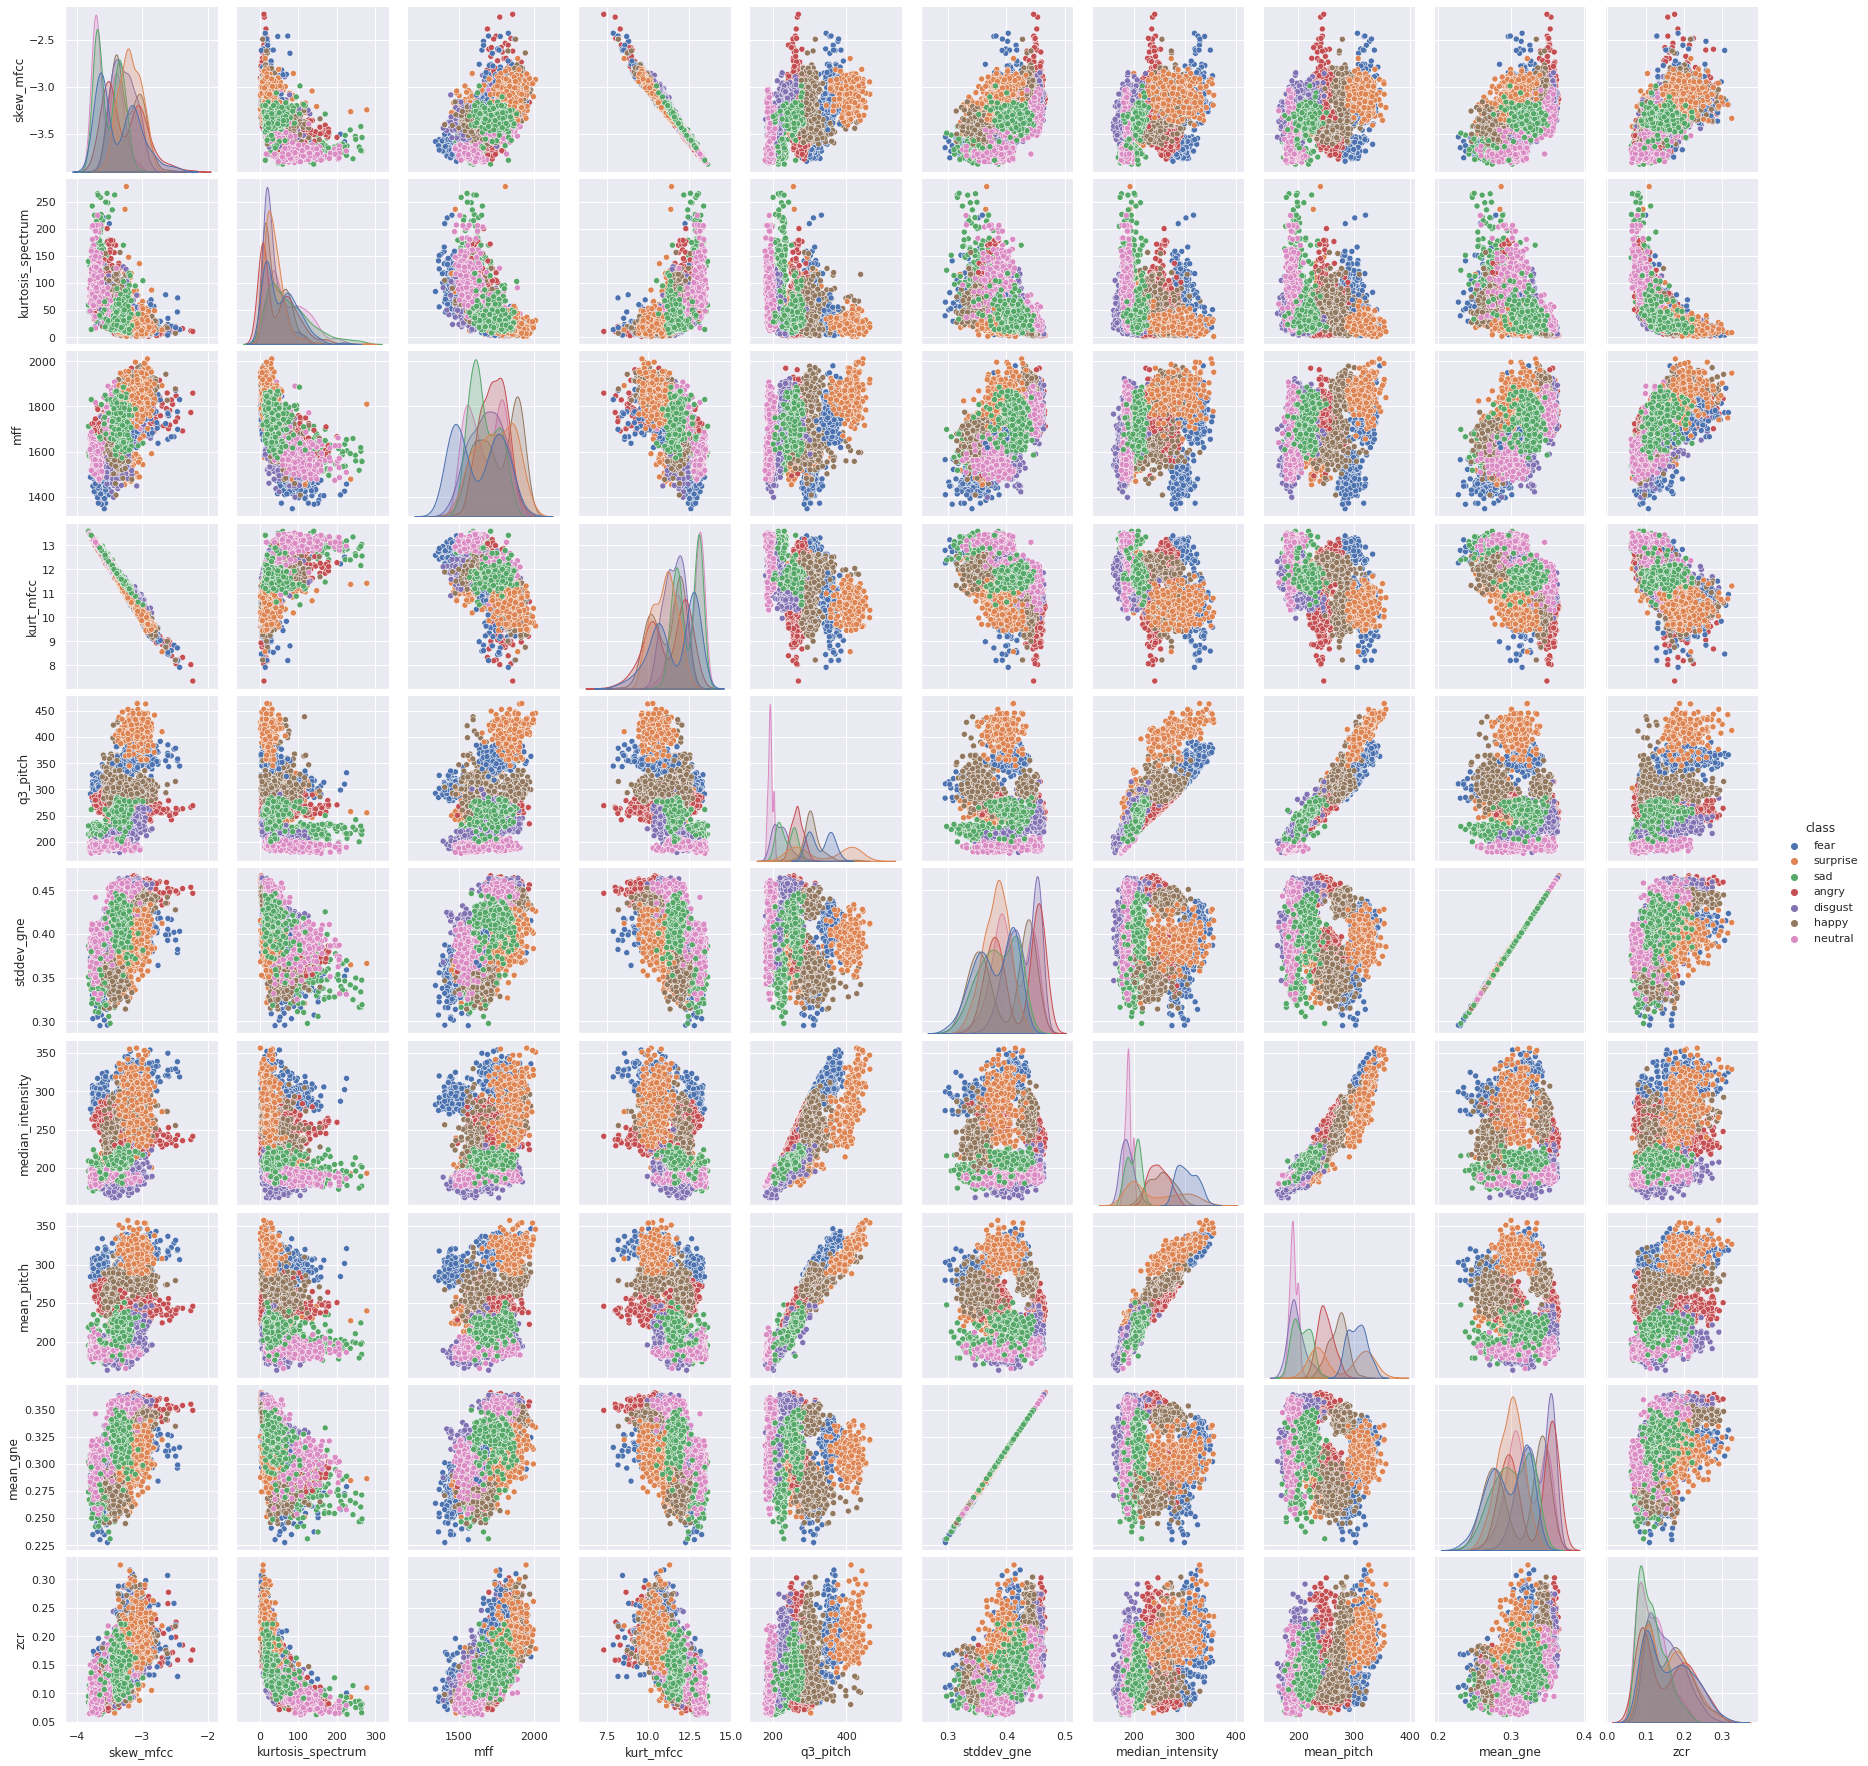

In [42]:
sns.pairplot(df, hue='class')
plt.show()

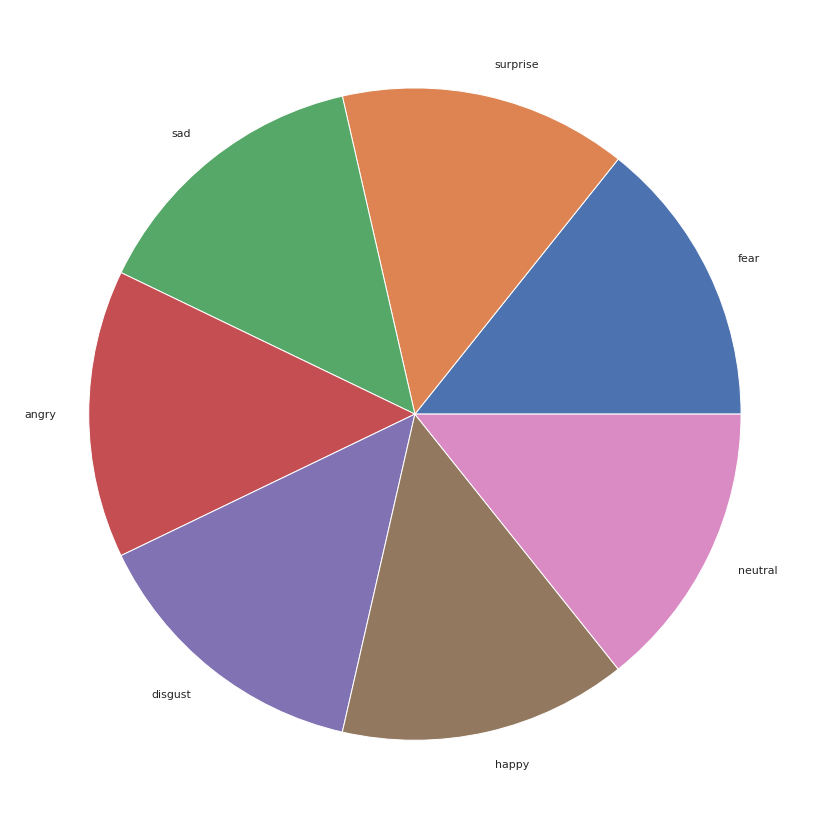

In [43]:
y =df['class']
y.value_counts().plot(kind='pie')
plt.ylabel('')
plt.show()

**Data Matrix**

In [44]:
X = df.drop(columns=['class'])
X.head(10)

skew_mfcc  kurtosis_spectrum          mff  kurt_mfcc    q3_pitch  \
0  -3.563734          74.268179  1413.812460  12.449193  301.183305   
1  -3.740945          74.189475  1643.453033  13.175386  291.232261   
2  -3.650129         158.337416  1403.740380  12.789972  306.612411   
3  -3.664902          95.916296  1522.232758  12.845008  307.946148   
4  -3.678127          46.126032  1413.076259  12.875223  295.411268   
5  -3.595865          97.190874  1438.996419  12.507008  323.469207   
6  -3.637153         153.032984  1383.648283  12.771718  288.393860   
7  -3.711355         141.504122  1442.385821  13.058541  316.587953   
8  -3.564624          83.014715  1566.515705  12.445365  319.055504   
9  -3.652258          85.971100  1493.818350  12.821523  290.990250   

   stddev_gne  median_intensity  mean_pitch  mean_gne       zcr  
0    0.338561        290.232726  289.718791  0.263435  0.098198  
1    0.320527        282.803744  279.778416  0.250087  0.127415  
2    0.352166        293.923331  296.279551  0.273001  0.083392  
3    0.376662        299.681446  298.477413  0.293178  0.095981  
4    0.331959        284.369671  284.444951  0.257937  0.171578  
5    0.384760        316.914077  314.772346  0.299831  0.091064  
6    0.364745        276.428576  280.799560  0.282641  0.092094  
7    0.356776        304.964277  307.201091  0.277659  0.090167  
8    0.354092        304.311608  304.220662  0.275720  0.095969  
9    0.374694        282.432678  282.409470  0.292803  0.097292

In [45]:
X.describe().transpose()

count         mean         std          min          25%  \
skew_mfcc          2800.0    -3.344885    0.261150    -3.824766    -3.553631   
kurtosis_spectrum  2800.0    52.220807   44.114414     1.320415    18.152376   
mff                2800.0  1698.939973  127.257859  1346.580570  1599.554734   
kurt_mfcc          2800.0    11.602204    1.087394     7.336643    10.799308   
q3_pitch           2800.0   270.087679   63.334603   178.235427   216.486932   
stddev_gne         2800.0     0.399394    0.037467     0.294913     0.370517   
median_intensity   2800.0   232.406654   46.498526   160.921411   191.209064   
mean_pitch         2800.0   242.235160   46.648526   162.850947   197.982785   
mean_gne           2800.0     0.312259    0.029720     0.227510     0.289228   
zcr                2800.0     0.145232    0.053404     0.062149     0.100226   

                           50%          75%          max  
skew_mfcc            -3.362424    -3.154600    -2.227348  
kurtosis_spectrum    39.231935    74.702459   278.005788  
mff                1705.989414  1797.306945  2010.241866  
kurt_mfcc            11.720152    12.424551    13.598106  
q3_pitch            262.462580   302.358685   463.779629  
stddev_gne            0.397758     0.432164     0.466557  
median_intensity    217.970938   270.616702   356.236962  
mean_pitch          236.651192   280.346535   357.328834  
mean_gne              0.310911     0.338412     0.365548  
zcr                   0.131841     0.184089     0.324894

**Standardize the Data**

In [46]:
Xs = StandardScaler().fit_transform(X)
Xcols = X.columns
X = pd.DataFrame(Xs)
X.columns = Xcols
X.head(10)

skew_mfcc  kurtosis_spectrum       mff  kurt_mfcc  q3_pitch  stddev_gne  \
0  -0.838172           0.499866 -2.240950   0.779056  0.491061   -1.623940   
1  -1.516868           0.498082 -0.436098   1.447004  0.333915   -2.105344   
2  -1.169055           2.405916 -2.320111   1.092502  0.576798   -1.260750   
3  -1.225631           0.990681 -1.388824   1.143124  0.597860   -0.606841   
4  -1.276283          -0.138183 -2.246736   1.170916  0.399910   -1.800175   
5  -0.961230           1.019578 -2.043017   0.832233  0.843000   -0.390651   
6  -1.119357           2.285652 -2.478024   1.075712  0.289091   -0.924953   
7  -1.403543           2.024265 -2.016378   1.339530  0.734331   -1.137692   
8  -0.841578           0.698171 -1.040784   0.775535  0.773299   -1.209345   
9  -1.177206           0.765199 -1.612146   1.121523  0.330093   -0.659376   

   median_intensity  mean_pitch  mean_gne       zcr  
0          1.243833    1.018084 -1.643130 -0.880881  
1          1.084036    0.804955 -2.092308 -0.333692  
2          1.323218    1.158751 -1.321175 -1.158179  
3          1.447074    1.205875 -0.642144 -0.922400  
4          1.117719    0.905009 -1.828132  0.493431  
5          1.817746    1.555250 -0.418262 -1.014484  
6          0.946907    0.826849 -0.996771 -0.995200  
7          1.560707    1.392917 -1.164441 -1.031301  
8          1.546668    1.329015 -1.229685 -0.922620  
9          1.076055    0.861367 -0.654784 -0.897858

In [47]:
X.describe().transpose()

count          mean       std       min       25%  \
skew_mfcc          2800.0  3.654220e-16  1.000179 -1.837897 -0.799478   
kurtosis_spectrum  2800.0  0.000000e+00  1.000179 -1.154033 -0.772412   
mff                2800.0 -1.380483e-15  1.000179 -2.769356 -0.781115   
kurt_mfcc          2800.0  6.496391e-16  1.000179 -3.923439 -0.738499   
q3_pitch           2800.0  3.654220e-16  1.000179 -1.450529 -0.846462   
stddev_gne         2800.0 -5.684342e-16  1.000179 -2.789109 -0.770887   
median_intensity   2800.0  2.030122e-16  1.000179 -1.537640 -0.886156   
mean_pitch         2800.0  8.120488e-17  1.000179 -1.702056 -0.948803   
mean_gne           2800.0  5.684342e-16  1.000179 -2.852118 -0.775099   
zcr                2800.0  1.624098e-16  1.000179 -1.556039 -0.842902   

                        50%       75%       max  
skew_mfcc         -0.067173  0.728772  4.280048  
kurtosis_spectrum -0.294489  0.509712  5.119082  
mff                0.055405  0.773112  2.446666  
kurt_mfcc          0.108488  0.756390  1.835819  
q3_pitch          -0.120415  0.509623  3.058779  
stddev_gne        -0.043692  0.874786  1.792901  
median_intensity  -0.310511  0.821894  2.663577  
mean_pitch        -0.119724  0.817136  2.467693  
mean_gne          -0.045374  0.880138  1.793361  
zcr               -0.250790  0.727753  3.364847

**Observations and variables**

In [48]:
observations = list(df.index)
variables = list(df.columns)

**Box and Whisker Plots**

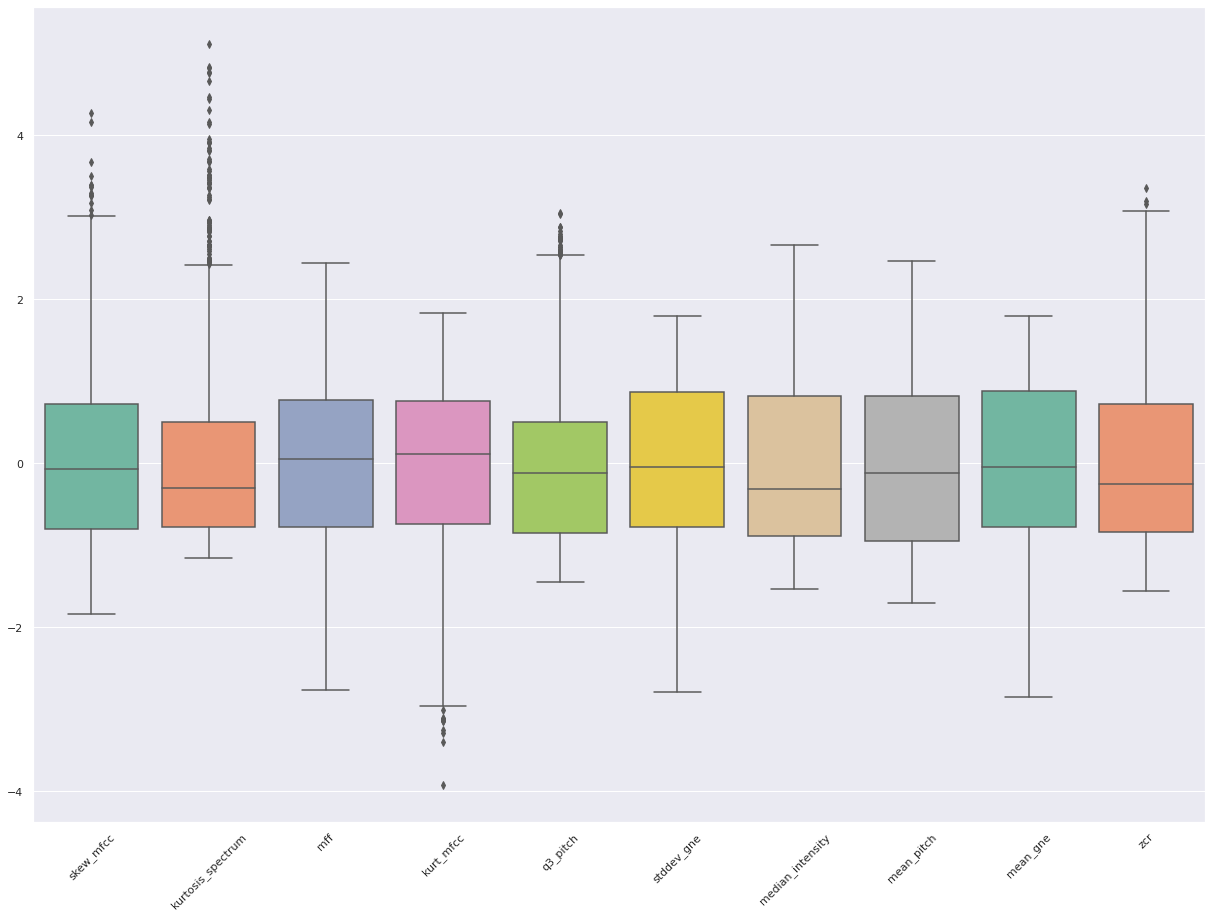

In [49]:
ax = plt.figure()
ax = sns.boxplot(data=X, orient="v", palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

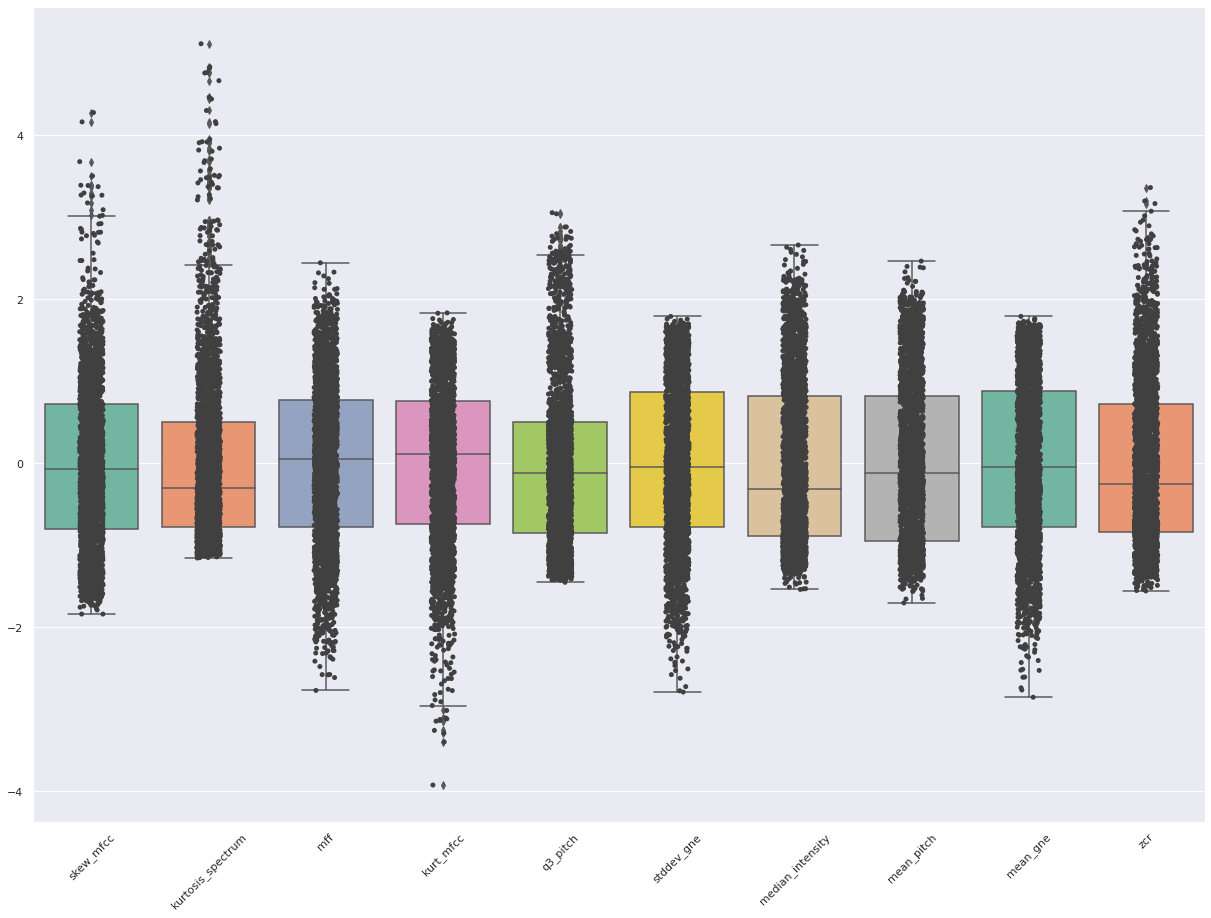

In [50]:
# Use swarmplot() or stripplot to show the datapoints on top of the boxes:
#plt. figure()
ax = plt.figure()    
ax = sns.boxplot(data=X, orient="v", palette="Set2")
ax = sns.stripplot(data=X, color=".25") 
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

**Correlation Matrix**

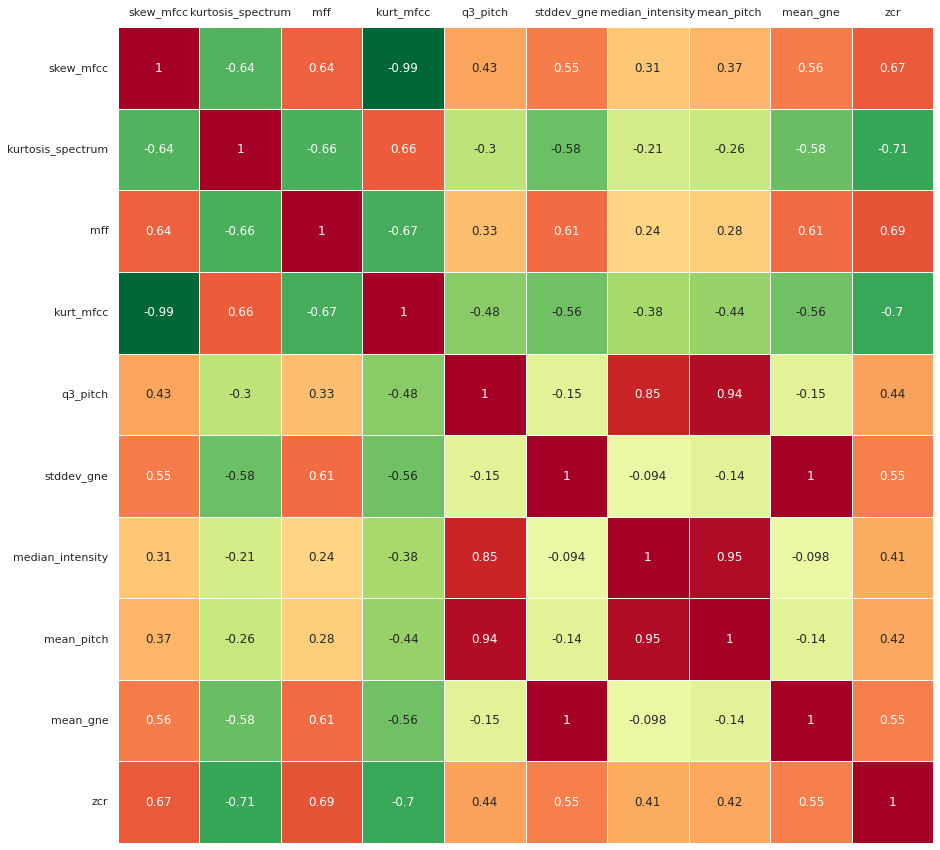

In [51]:
ax = sns.heatmap(X.corr(), cmap='RdYlGn_r', linewidths=0.5, annot=True, cbar=False, square=True)
plt.yticks(rotation=0)
ax.tick_params(labelbottom=False,labeltop=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=0);

#X.corr().style.background_gradient(cmap='coolwarm').set_precision(2)
#sns.clustermap(X.corr(), annot=True, fmt='.2f')

## **Principal Component Analysis (PCA)**

Text(0, 0.5, '$Z_2$')

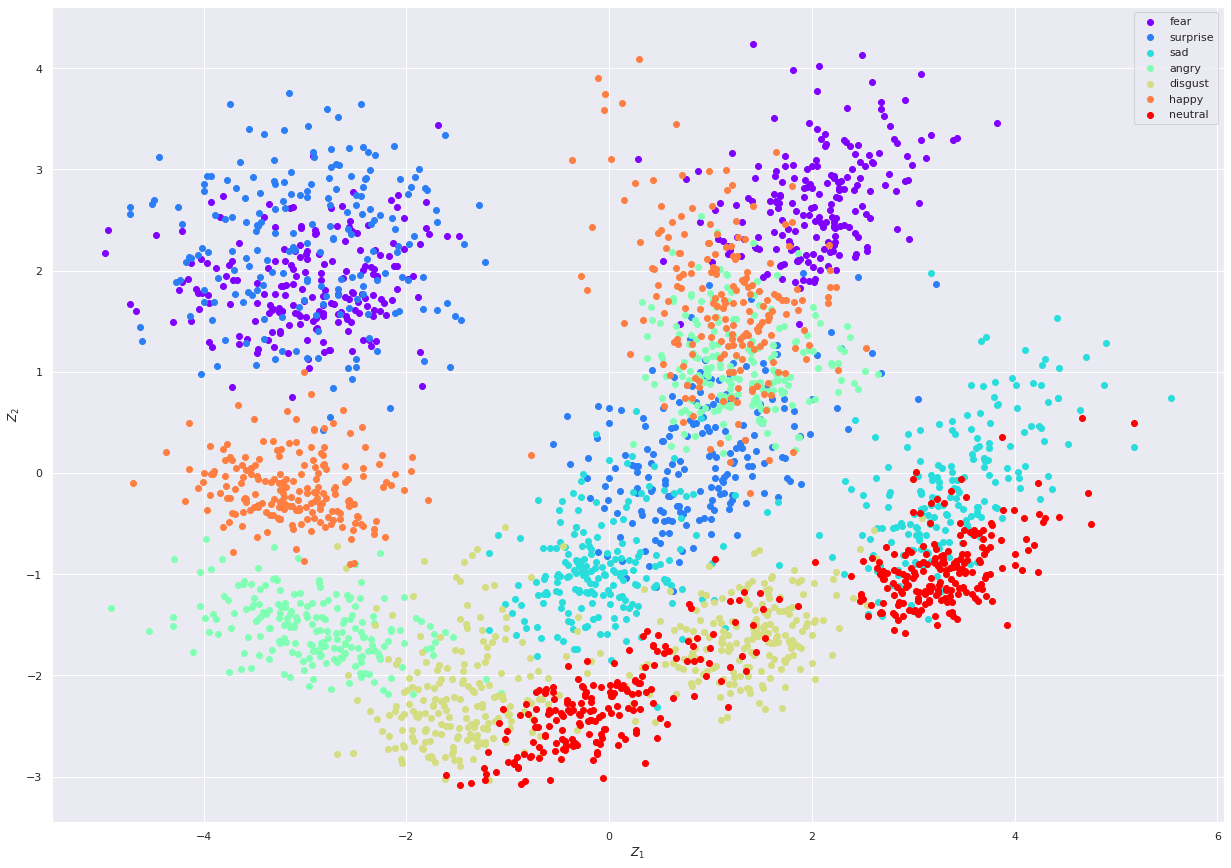

In [52]:
import matplotlib.cm as cm
pca = PCA()
Z = pca.fit_transform(X)

'''idx_fear = np.where(y == 'fear')
idx_surprise = np.where(y == 'surprise')
idx_sad = np.where(y == 'sad')
idx_angry = np.where(y == 'angry')
idx_disgust = np.where(y == 'disgust')
idx_happy = np.where(y == 'happy')
idx_neutral = np.where(y == 'neutral')'''

plt.figure()
idx_dic = {}
colors = cm.rainbow(np.linspace(0, 1, len(df['class'].unique())))
for i in df['class'].unique():
    idx_dic.update({f'idx_{i}': np.where(y == i)})
    plt.scatter(Z[idx_dic.get(f'idx_{i}'),0], Z[idx_dic.get(f'idx_{i}'),1], c=[colors[list(df['class'].unique()).index(i)]], label=i)

'''plt.scatter(Z[idx_fear,0], Z[idx_fear,1], c=[colors[0]], label='fear')
plt.scatter(Z[idx_surprise,0], Z[idx_surprise,1], c=[colors[1]], label='surprise')
plt.scatter(Z[idx_sad,0], Z[idx_sad,1], c=[colors[2]], label='sad')
plt.scatter(Z[idx_angry,0], Z[idx_angry,1], c=[colors[3]], label='angry')
plt.scatter(Z[idx_disgust,0], Z[idx_disgust,1], c=[colors[4]], label='disgust')
plt.scatter(Z[idx_happy,0], Z[idx_happy,1], c=[colors[5]], label='happy')
plt.scatter(Z[idx_neutral,0], Z[idx_neutral,1], c=[colors[6]], label='neutral')'''
plt.legend()
plt.xlabel('$Z_1$')
plt.ylabel('$Z_2$')

**Eigenvectors**

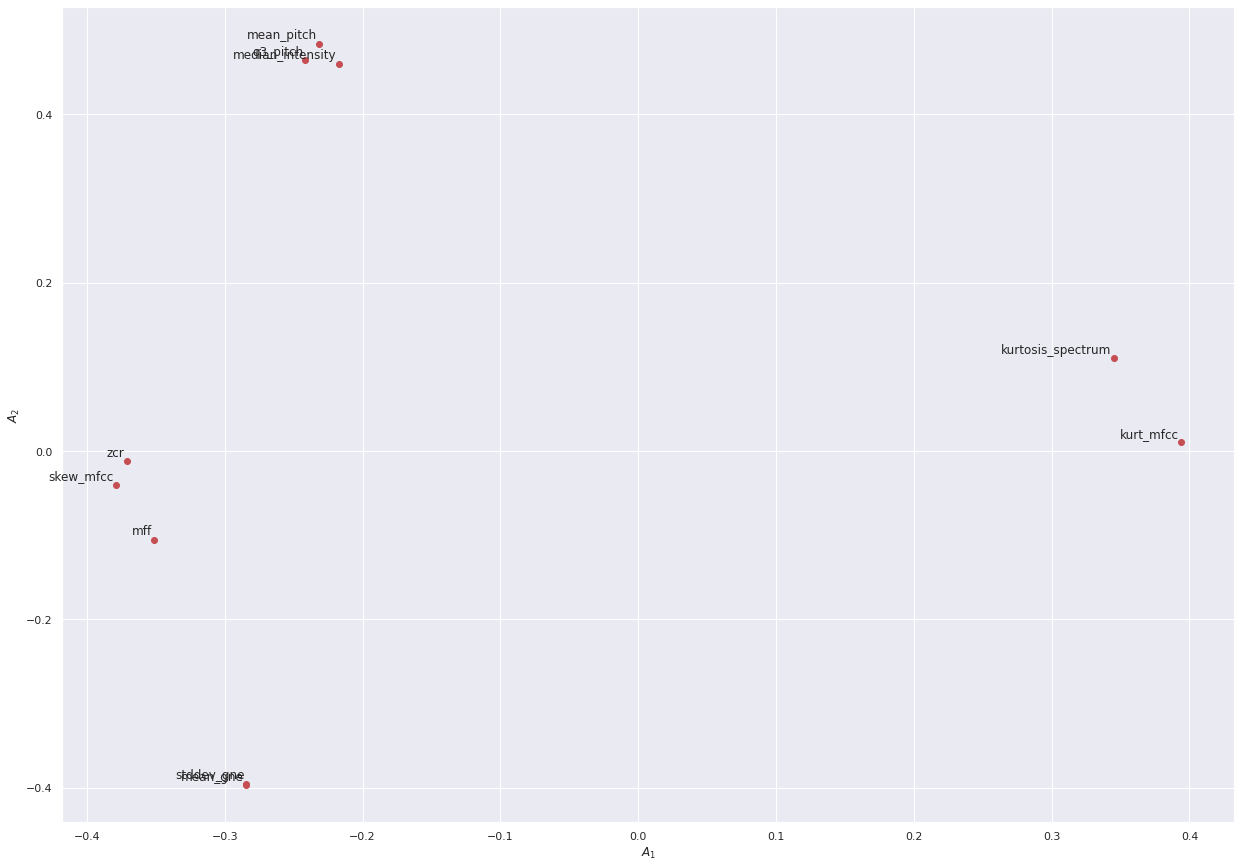

In [53]:
A = pca.components_.T 

plt.scatter(A[:,0],A[:,1],c='r')
plt.xlabel('$A_1$')
plt.ylabel('$A_2$')
for label, x, y in zip(variables, A[:, 0], A[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-2, 2), textcoords='offset points', ha='right', va='bottom')

/home/alaa/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


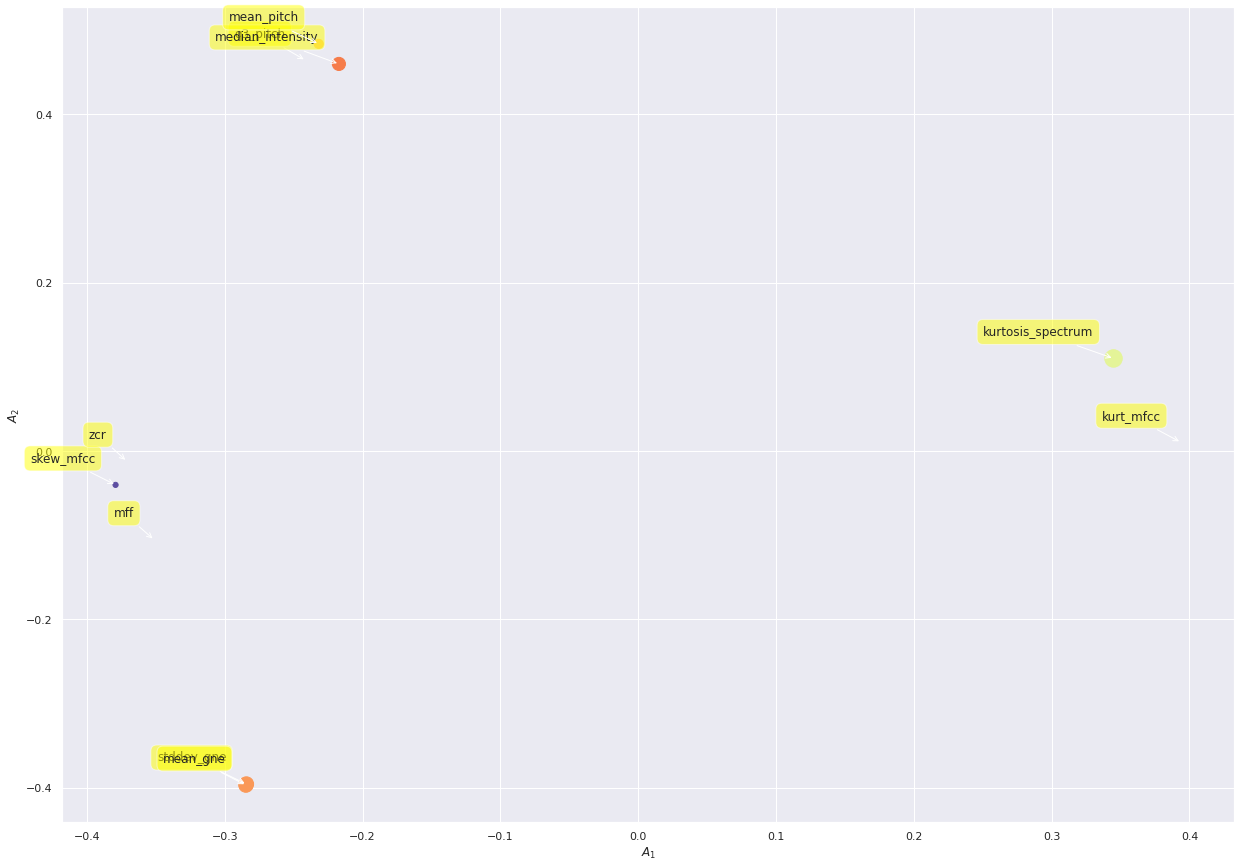

In [54]:
plt.scatter(A[:, 0],A[:, 1], marker='o', c=A[:, 2], s=A[:, 3]*500, cmap=plt.get_cmap('Spectral'))
plt.xlabel('$A_1$')
plt.ylabel('$A_2$')
for label, x, y in zip(variables,A[:, 0],A[:, 1]):
    plt.annotate(label,xy=(x, y), xytext=(-20, 20),
    textcoords='offset points', ha='right', va='bottom',
    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
    arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

**Scree plot**

Text(0, 0.5, 'Explained variance')

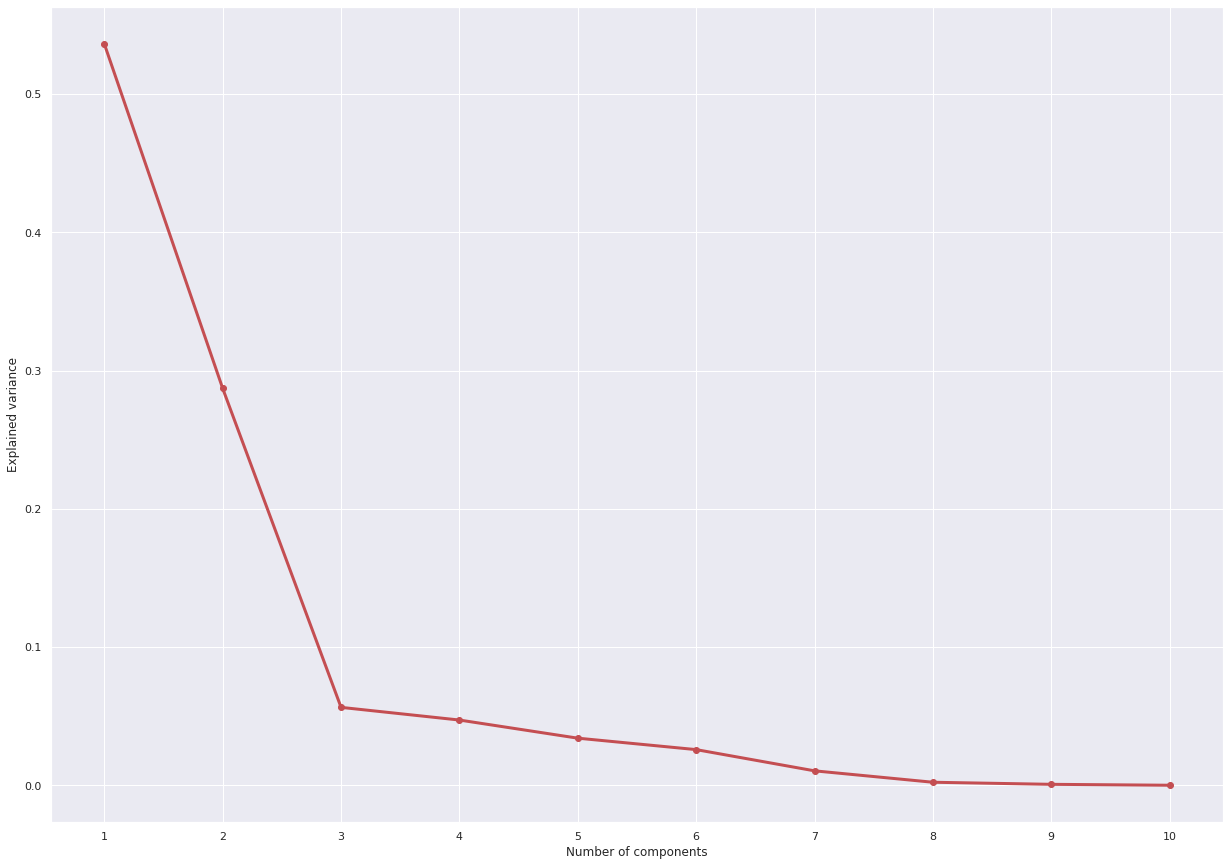

In [55]:
#Eigenvalues
Lambda = pca.explained_variance_ 

#Scree plot
x = np.arange(len(Lambda)) + 1
plt.plot(x,Lambda/sum(Lambda), 'ro-', lw=3)
plt.xticks(x, [""+str(i) for i in x], rotation=0)
plt.xlabel('Number of components')
plt.ylabel('Explained variance') 

**Explained Variance**

Text(0, 0.5, 'Cumulative explained variance')

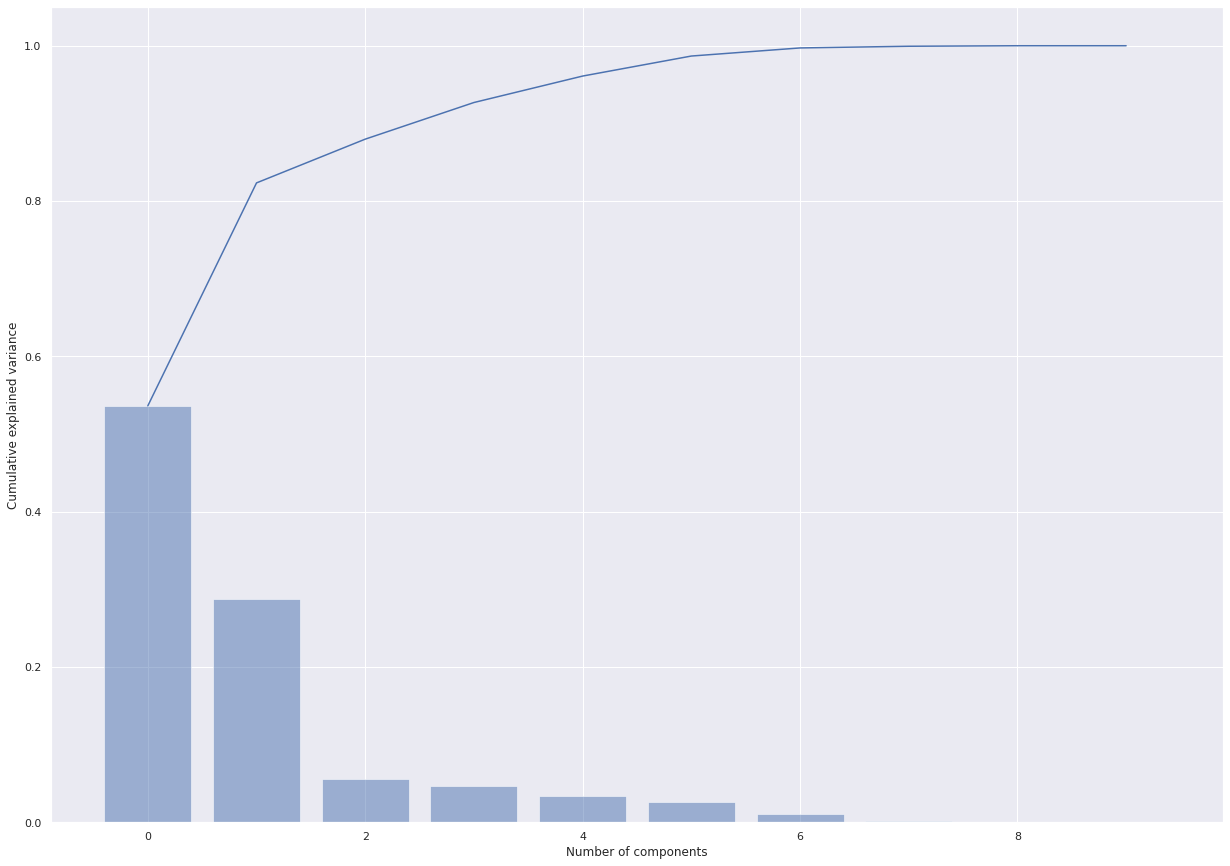

In [56]:
ell = pca.explained_variance_ratio_
ind = np.arange(len(ell))
plt.bar(ind, ell, align='center', alpha=0.5)
plt.plot(np.cumsum(ell))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

**Biplot**

Text(0, 0.5, '$Z_2$')

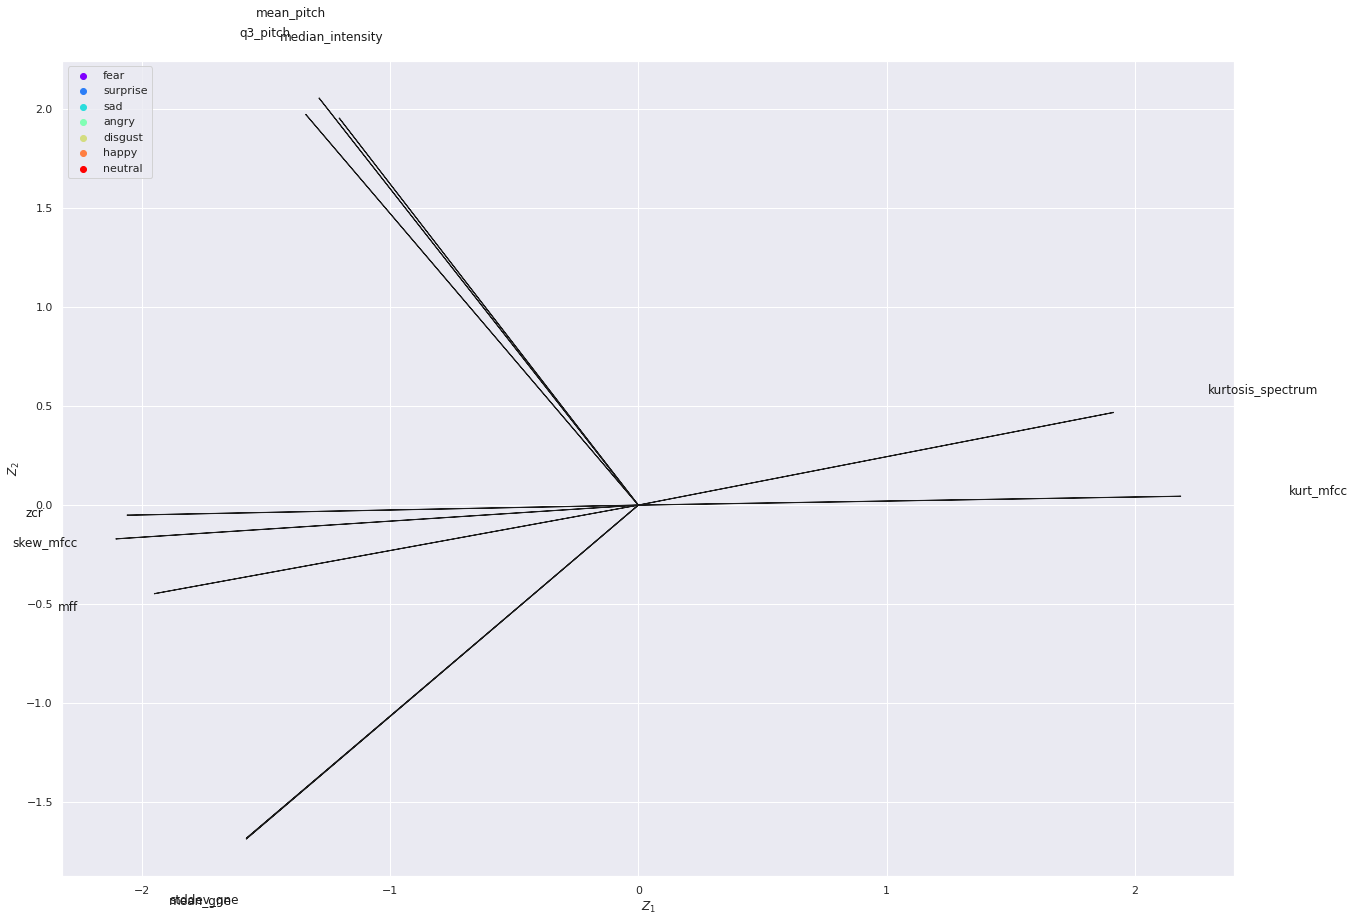

In [57]:
A1 = A[:,0] 
A2 = A[:,1]
Z1 = Z[:,0] 
Z2 = Z[:,1]

plt.figure()
idx_dic = {}
colors = cm.rainbow(np.linspace(0, 1, len(df['class'].unique())))

for i in range(len(A1)):
# arrows project features as vectors onto PC axes
    plt.arrow(0, 0, A1[i]*max(Z1), A2[i]*max(Z2), color='k', width=0.0005, head_width=0.0025)
    plt.text(A1[i]*max(Z1)*1.2, A2[i]*max(Z2)*1.2,variables[i], color='k')
    
for i in df['class'].unique():
    idx_dic.update({f'idx_{i}': np.where(y == i)})
    plt.scatter(Z[idx_dic.get(f'idx_{i}'),0], Z[idx_dic.get(f'idx_{i}'),1], c=[colors[list(df['class'].unique()).index(i)]], label=i)

plt.legend(loc='upper left')
plt.xlabel('$Z_1$')
plt.ylabel('$Z_2$')

## **Using PCA Library**

In [58]:
!pip install pca

In [59]:
from pca import pca
# Initialize and keep all PCs
model = pca()
# Fit transform
out = model.fit_transform(X)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [10] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [10] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


**Principal Components**

In [60]:
out.keys()

dict_keys(['loadings', 'PC', 'explained_var', 'variance_ratio', 'model', 'scaler', 'pcp', 'topfeat', 'outliers', 'outliers_params'])

In [61]:
out['loadings']

skew_mfcc  kurtosis_spectrum       mff  kurt_mfcc  q3_pitch  stddev_gne  \
PC1  -0.379216           0.344941 -0.351296   0.393786 -0.241419   -0.284300   
PC2  -0.040110           0.110082 -0.105244   0.010523  0.464260   -0.395457   
PC3   0.623189           0.164692 -0.210696  -0.530658 -0.005006   -0.223886   
PC4   0.053556           0.609791 -0.263466  -0.078683 -0.014954    0.416648   
PC5  -0.025990           0.446218  0.847167   0.005533  0.096523   -0.074215   

     median_intensity  mean_pitch  mean_gne       zcr  
PC1         -0.217156   -0.231806 -0.284638 -0.371099  
PC2          0.459949    0.483779 -0.396767 -0.011976  
PC3         -0.270084   -0.128636 -0.220132 -0.265368  
PC4          0.343943    0.166943  0.408626 -0.250440  
PC5         -0.107645   -0.032839 -0.069291 -0.224052

In [62]:
out['explained_var']

array([0.53628462, 0.82336213, 0.87970321, 0.92687871, 0.96093995,
       0.9867223 , 0.99715143, 0.9993223 , 0.99998988, 1.        ])

In [63]:
out['variance_ratio']

array([5.36284618e-01, 2.87077513e-01, 5.63410791e-02, 4.71755056e-02,
       3.40612362e-02, 2.57823461e-02, 1.04291331e-02, 2.17087465e-03,
       6.67573577e-04, 1.01216383e-05])

In [64]:
out['PC']

PC1       PC2       PC3       PC4       PC5
0     2.215913  2.929983  0.108411  0.252039 -1.337505
1     2.285360  2.886566 -0.916754 -0.922821  0.165329
2     2.987568  3.041028 -0.052100  1.794636 -0.535743
3     1.704042  2.348736 -0.941581  1.220286 -0.537794
4     1.986664  2.853661 -0.711875 -0.743908 -1.887091
...        ...       ...       ...       ...       ...
2795  0.130741 -0.696102  1.080209  0.643785 -0.234517
2796 -0.585387 -0.739657  0.396023  0.458412 -0.872143
2797 -0.342219 -1.736420  0.014174  0.409301  0.615328
2798 -1.022254 -1.295935 -0.982893 -0.508018  0.169428
2799 -0.524953 -0.744533 -0.154087 -0.985671  0.649595

[2800 rows x 5 columns]

**Scatter plot**

[colourmap]> Warning: Colormap [Set1] can not create [2800] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [2800] unique colors! Available unique colors: [9].
[pca] >Set parameter "label=None" to ignore the labels and significanly speed up the scatter plot.


(<Figure size 1440x1080 with 1 Axes>,
 <AxesSubplot:title={'center':'5 Principal Components explain [98.67%] of the variance'}, xlabel='PC1 (53.6% expl.var)', ylabel='PC2 (28.7% expl.var)'>)

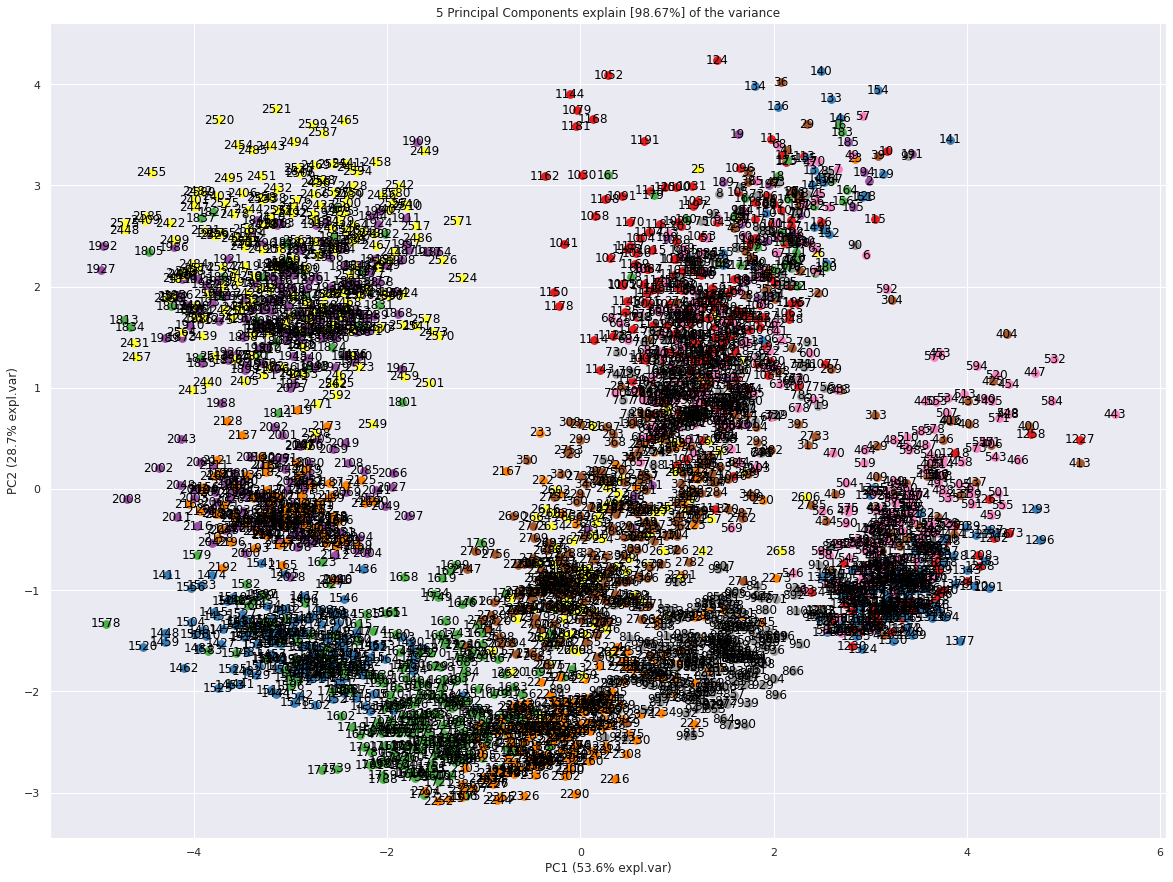

In [65]:
model.scatter(label=True, legend=False)

**Eigenvectors**

In [66]:
A = out['loadings'].T

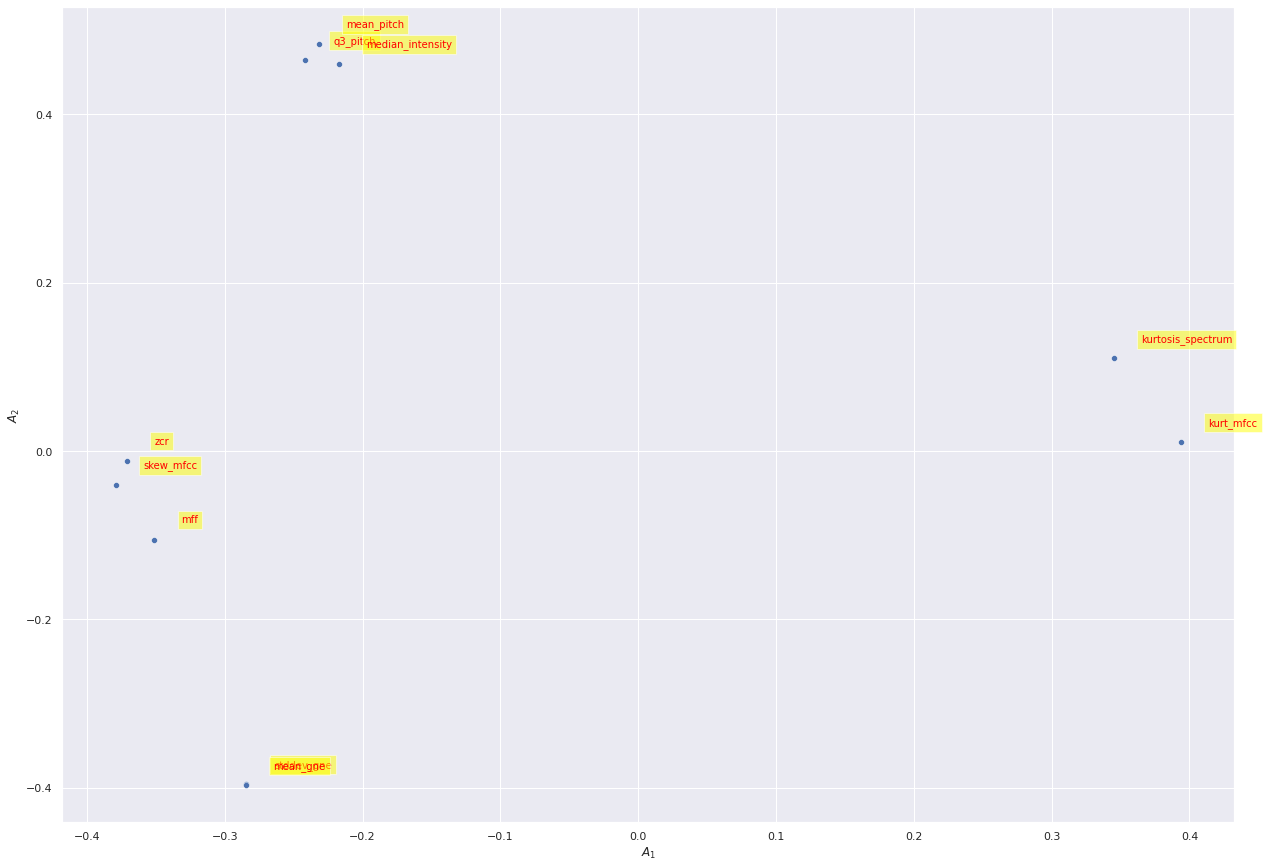

In [67]:
sns.scatterplot(data=A, x="PC1", y="PC2")
plt.xlabel('$A_1$')
plt.ylabel('$A_2$')
for i in range(A.shape[0]):
    plt.text(x=A.PC1[i]+0.02,y=A.PC2[i]+0.02, s=variables[i],
          fontdict=dict(color='red',size=10),
          bbox=dict(facecolor='yellow',alpha=0.5))

**Scree Plot**

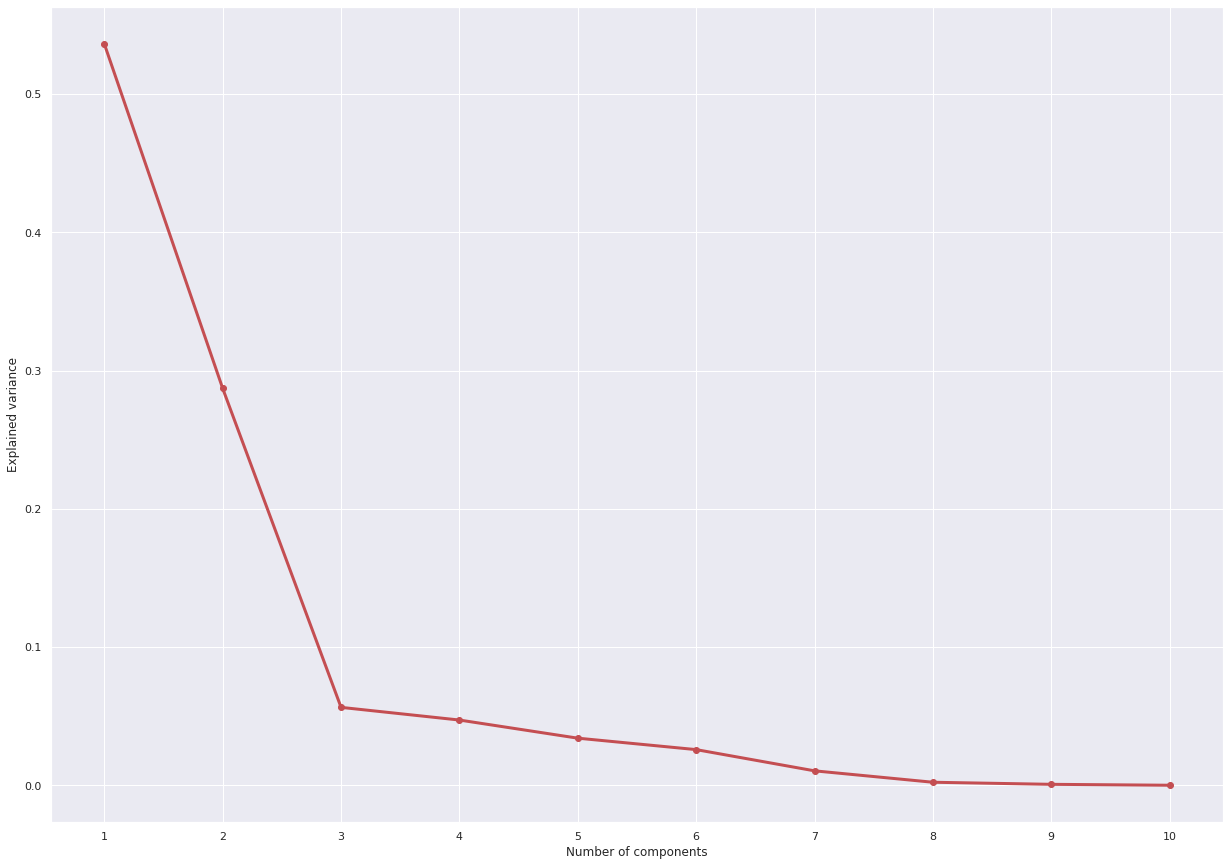

In [68]:
VR = out['variance_ratio']
x = np.arange(len(VR)) + 1
plt.plot(x, VR, 'ro-', lw=3)
plt.xticks(x, [""+str(i) for i in x], rotation=0)
plt.xlabel('Number of components')
plt.ylabel('Explained variance') 
plt.show()

**Explained Variance Plot**

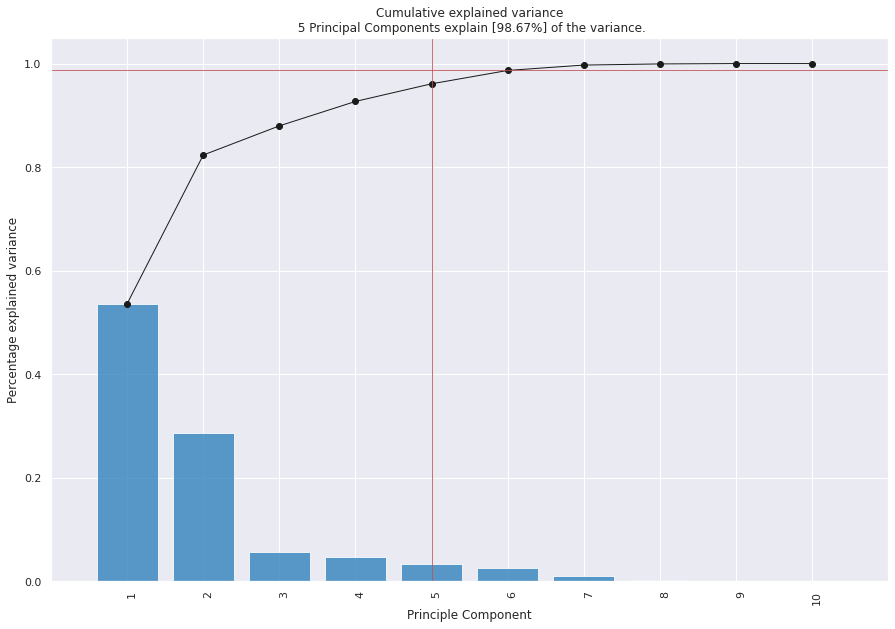

<Figure size 1512x1080 with 0 Axes>

In [69]:
model.plot();

**Biplot**

[pca] >Plot PC1 vs PC2 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [2800] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [2800] unique colors! Available unique colors: [9].
[pca] >Set parameter "label=None" to ignore the labels and significanly speed up the scatter plot.


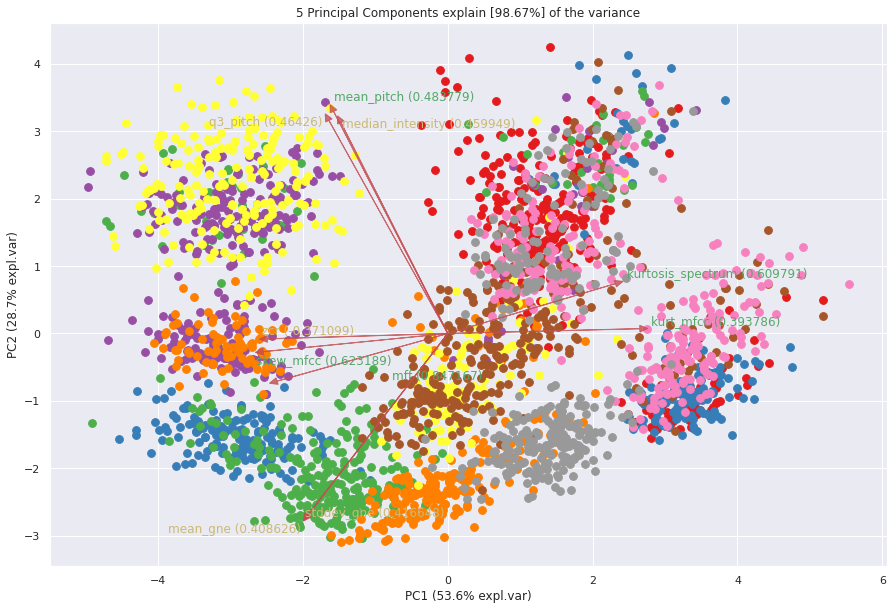

(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:title={'center':'5 Principal Components explain [98.67%] of the variance'}, xlabel='PC1 (53.6% expl.var)', ylabel='PC2 (28.7% expl.var)'>)

In [70]:
model.biplot(label=False, legend=False)

[pca] >Plot PC1 vs PC2 vs PC3 with loadings.
[colourmap]> Warning: Colormap [Set1] can not create [2800] unique colors! Available unique colors: [9].
[colourmap]> Warning: Colormap [Set1] can not create [2800] unique colors! Available unique colors: [9].
[pca] >Set parameter "label=None" to ignore the labels and significanly speed up the scatter plot.


/home/alaa/anaconda3/envs/tf/lib/python3.7/site-packages/pca/pca.py:1132: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)


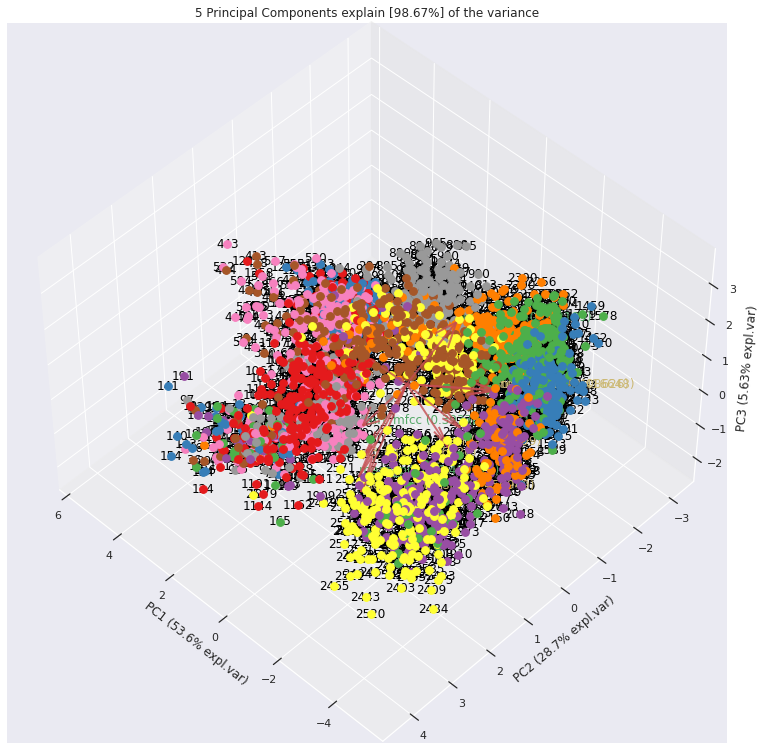

(<Figure size 1080x720 with 2 Axes>,
 <Axes3D:title={'center':'5 Principal Components explain [98.67%] of the variance'}, xlabel='PC1 (53.6% expl.var)', ylabel='PC2 (28.7% expl.var)'>)

In [71]:
model.biplot3d(legend=False)

# **Classification**

**Using PyCaret**

PyCaret uses interactive plotting ability. In order to render interactive plots in Google Colab, run the below line of code in your colab notebook.

In [72]:
#For Google Colab only
from pycaret.utils import enable_colab 
enable_colab()

Colab mode enabled.


In order to demonstrate the predict_model() function on unseen data, a sample of 280 observations has been withheld from the original dataset to be used for predictions. This should not be confused with a train/test split as this particular split is performed to simulate a real life scenario. Another way to think about this is that these 280 records were not available at the time when the machine learning experiment was performed.

In [73]:
data = df.sample(frac=0.9, random_state=786)
data_unseen = df.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (2520, 11)
Unseen Data For Predictions: (280, 11)


**Setting up the Environment in PyCaret**

The setup() function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. setup() must be called before executing any other function in pycaret. It takes two mandatory parameters: a pandas dataframe and the name of the target column. All other parameters are optional and are used to customize the pre-processing pipeline (we will see them in later tutorials).

When setup() is executed, PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. The data type should be inferred correctly but this is not always the case. To account for this, PyCaret displays a table containing the features and their inferred data types after setup() is executed. If all of the data types are correctly identified enter can be pressed to continue or quit can be typed to end the expriment. Ensuring that the data types are correct is of fundamental importance in PyCaret as it automatically performs a few pre-processing tasks which are imperative to any machine learning experiment. These tasks are performed differently for each data type which means it is very important for them to be correctly configured.

In [74]:
from pycaret.classification import *
clf = setup(data=data, target='class', train_size=0.7, session_id=123, data_split_stratify=True)

Once the setup has been succesfully executed it prints the information grid which contains several important pieces of information. Most of the information is related to the pre-processing pipeline which is constructed when setup() is executed. The majority of these features are out of scope for the purposes of this tutorial however a few important things to note at this stage include:

* **session_id** : A pseduo-random number distributed as a seed in all functions for later reproducibility. If no session_id is passed, a random number is automatically generated that is distributed to all functions. In this experiment, the session_id is set as 123 for later reproducibility.

* **Target Type** : Binary or Multiclass. The Target type is automatically detected and shown. There is no difference in how the experiment is performed for Binary or Multiclass problems. All functionalities are identical.

* **Label Encoded** : When the Target variable is of type string (i.e. 'Yes' or 'No') instead of 1 or 0, it automatically encodes the label into 1 and 0 and displays the mapping (0 : No, 1 : Yes) for reference. 

* **Original Data** : Displays the original shape of the dataset. In this experiment (189, 8) means 189 samples and 8 features including the class column.

* **Missing Values** : When there are missing values in the original data this will show as True. For this experiment there are no missing values in the dataset.

* **Numeric Features** : The number of features inferred as numeric. In this dataset, 7 out of 8 features are inferred as numeric.

* **Categorical Features** : The number of features inferred as categorical. In this dataset, there are no categorical features.

* **Transformed Train Set** : Displays the shape of the transformed training set. Notice that the original shape of (189, 8) is transformed into (132, 7) for the transformed train set.

* **Transformed Test Set** : Displays the shape of the transformed test/hold-out set. There are 57 samples in test/hold-out set. This split is based on the default value of 70/30 that can be changed using the train_size parameter in setup.

Notice how a few tasks that are imperative to perform modeling are automatically handled such as missing value imputation, categorical encoding etc. Most of the parameters in setup() are optional and used for customizing the pre-processing pipeline. 

**Comparing All Models**

In [75]:
 #show the best model and their statistics
best_model = compare_models()

In [76]:
best_model

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

**Create a Model**

create_model is the most granular function in PyCaret and is often the foundation behind most of the PyCaret functionalities. As the name suggests this function trains and evaluates a model using cross validation that can be set with fold parameter. The output prints a score grid that shows Accuracy, Recall, Precision, F1, Kappa and MCC by fold.

For the remaining part of this tutorial, we will work with the below models as our candidate models. The selections are for illustration purposes only and do not necessarily mean they are the top performing or ideal for this type of data.

* Decision Tree Classifier ('dt')
* K Neighbors Classifier ('knn')
* Logistic Regression ('lr')

There are many classifiers available in the model library of PyCaret. Please view the create_model() docstring for the list of all available models.

**Create Decision Tree Classifier**

In [77]:
dt = create_model('dt')

In [78]:
#trained model object is stored in the variable 'dt'. 
dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

**Tune a Model:** How to automatically tune the hyper-parameters of a multiclass model. When a model is created using the create_model() function it uses the default hyperparameters. In order to tune hyperparameters, the tune_model() function is used. The tune_model() function is a random grid search of hyperparameters over a pre-defined search space. By default, it is set to optimize Accuracy but this can be changed using optimize parameter. This function automatically tunes the hyperparameters of a model on a pre-defined search space and scores it using stratified cross validation. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1 and Kappa by fold.

**Tune Decision Tree Model**

In [79]:
tuned_dt = tune_model(dt)

In [80]:
#tuned model object is stored in the variable 'tuned_dt'. 
tuned_dt

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

**Evaluate Decision Tree Model**

Update statmodels

In [81]:
!pip install statsmodels --upgrade

How to analyze model performance using various plots

In [82]:
evaluate_model(tuned_dt)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

**Create K Neighbors Model**

In [83]:
knn = create_model('knn')

**Tune K Neighbors Model**

In [84]:
tuned_knn = tune_model(knn, custom_grid = {'n_neighbors' : np.arange(0,50,1)})

**Evaluate K Neighbors Model**

**Create Logistic Regression Model**

In [85]:
lr = create_model('lr')

**Tune Logistic Regression Model**

In [86]:
tuned_lr = tune_model(lr)

**Evaluate Logistic Regression Model**

In [87]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

**Create Random Forest Model**

In [88]:
rf = create_model('rf')

**Tune Random Forest Model**

In [89]:
tuned_rf = tune_model(rf)

**Evaluate Random Forest Model**

In [90]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# **Tune the Best Model**

In [91]:
# Tune hyperparameters with scikit-learn (default)
tuned_best_model = tune_model(best_model)

In [92]:
tuned_best_model

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=6, max_features=1.0, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0,
                     min_impurity_split=None, min_samples_leaf=4,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)

**Evaluate the Best Model**

One way to analyze the performance of models is to use the evaluate_model() function which displays a user interface for all of the available plots for a given model. It internally uses the plot_model() function.

In [93]:
evaluate_model(tuned_best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# **Classification + PCA**

In [94]:
clf_pca = setup(data=data, target='class', train_size=0.7, session_id=123, normalize = True, pca = True, pca_components = 5, data_split_stratify=True)

In [95]:
#show the best model and their statistics
best_model_pca = compare_models()

In [96]:
best_model_pca

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

**Tune the Best Model**

In [97]:
# Tune hyperparameters with scikit-learn (default)
tuned_best_model_pca = tune_model(best_model_pca)

In [98]:
tuned_best_model_pca

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=6, max_features=1.0, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0,
                     min_impurity_split=None, min_samples_leaf=4,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)

**Evaluate the Best Model**

One way to analyze the performance of models is to use the evaluate_model() function which displays a user interface for all of the available plots for a given model. It internally uses the plot_model() function.

**Note:** The AUC metric is not available for Multiclass classification however the column will still be shown with zero values to maintain consistency between the Binary Classification and Multiclass Classification display grids.

### K Neighbors Classifier

In [99]:
knn_pca = create_model('knn')

In [100]:
tuned_knn_pca = tune_model(knn_pca)

In [101]:
evaluate_model(tuned_knn_pca)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Random forest Classifier

In [102]:
rf_pca = create_model('rf')

In [103]:
tuned_rf_pca = tune_model(rf_pca)

In [104]:
evaluate_model(tuned_rf_pca)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# **Explainable AI with Shapley values**

Shapley values are a widely used approach from cooperative game theory that come with desirable properties.

In [105]:
!pip install shap

In [106]:
print("Numpy version: ", np.__version__)

Numpy version:  1.19.5


In [107]:
!pip install numba==0.53

In [108]:
import shap

In [109]:
et_pca = create_model('et')

In [110]:
tuned_et_pca = tune_model(et_pca)

**SHAP Summary Plot**

Rather than using a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. 

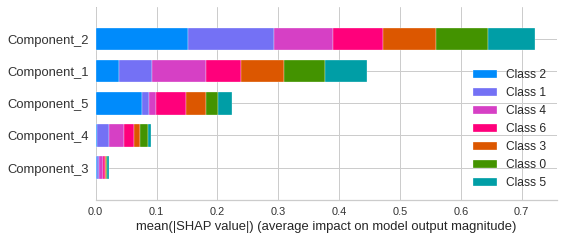

In [111]:
interpret_model(tuned_et_pca, plot='summary')

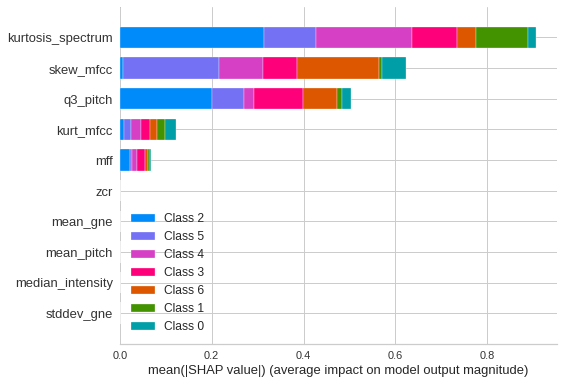

In [112]:
explainer = shap.TreeExplainer(tuned_et_pca)
X = df.drop('class', axis=1)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

**Visualize a single prediction**

In [113]:
interpret_model(tuned_et_pca, plot='reason', observation=9)

From the above the plot, we can seethe "base value," which is defined as the mean predicted target; and f(x), which is the prediction for a selected observation (i.e. observation number 32). The red-colored features increased the predicted value, while the blue-colored features decreased it. The size of each feature (i.e. Principal Component) indicates the impact it has on the model.

**Visualize many predictions**

In [114]:
interpret_model(tuned_et_pca, plot='reason')

Thank you ! 